In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'freehand_v2_mp_iq'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return modules, phases

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","([0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","([0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","([0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","([0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","([0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","([0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","([0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","([0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","([0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = []

for i in range(0, len(dataset_df.index)):
    I = dataset_df[iq_signals_column_dataframe_name][i][0]
    Q = dataset_df[iq_signals_column_dataframe_name][i][1]
    module = dataset_df[module_phase_signals_column_dataframe_name][i][0]
    phase = dataset_df[module_phase_signals_column_dataframe_name][i][1]
    
    signals.append([I, Q, module, phase])
    
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 4, 128)
[4, 128]


In [16]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 4, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0     

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 32:27 - loss: 2.4020

  2/151 [..............................] - ETA: 17s - loss: 2.3991  

  3/151 [..............................] - ETA: 17s - loss: 2.3951

  4/151 [..............................] - ETA: 17s - loss: 2.3903

  5/151 [..............................] - ETA: 16s - loss: 2.3853

  6/151 [>.............................] - ETA: 16s - loss: 2.3796

  7/151 [>.............................] - ETA: 16s - loss: 2.3732

  8/151 [>.............................] - ETA: 16s - loss: 2.3671

  9/151 [>.............................] - ETA: 16s - loss: 2.3612

 10/151 [>.............................] - ETA: 16s - loss: 2.3552

 11/151 [=>............................] - ETA: 16s - loss: 2.3492

 12/151 [=>............................] - ETA: 16s - loss: 2.3436

 13/151 [=>............................] - ETA: 15s - loss: 2.3381

 14/151 [=>............................] - ETA: 15s - loss: 2.3328

 15/151 [=>............................] - ETA: 15s - loss: 2.3278

 16/151 [==>...........................] - ETA: 15s - loss: 2.3230

 17/151 [==>...........................] - ETA: 15s - loss: 2.3183

 18/151 [==>...........................] - ETA: 15s - loss: 2.3139

 19/151 [==>...........................] - ETA: 15s - loss: 2.3096

 20/151 [==>...........................] - ETA: 15s - loss: 2.3054

 21/151 [===>..........................] - ETA: 14s - loss: 2.3014

 22/151 [===>..........................] - ETA: 14s - loss: 2.2977

 23/151 [===>..........................] - ETA: 14s - loss: 2.2941

 24/151 [===>..........................] - ETA: 14s - loss: 2.2906

 25/151 [===>..........................] - ETA: 14s - loss: 2.2873

 26/151 [====>.........................] - ETA: 14s - loss: 2.2840

 27/151 [====>.........................] - ETA: 14s - loss: 2.2809

 28/151 [====>.........................] - ETA: 14s - loss: 2.2778

 29/151 [====>.........................] - ETA: 14s - loss: 2.2748

 30/151 [====>.........................] - ETA: 13s - loss: 2.2719

 31/151 [=====>........................] - ETA: 13s - loss: 2.2690

 32/151 [=====>........................] - ETA: 13s - loss: 2.2663

 33/151 [=====>........................] - ETA: 13s - loss: 2.2636

 34/151 [=====>........................] - ETA: 13s - loss: 2.2609

 35/151 [=====>........................] - ETA: 13s - loss: 2.2584

 36/151 [======>.......................] - ETA: 13s - loss: 2.2559

 37/151 [======>.......................] - ETA: 13s - loss: 2.2534

 38/151 [======>.......................] - ETA: 13s - loss: 2.2511

 39/151 [======>.......................] - ETA: 12s - loss: 2.2487

 40/151 [======>.......................] - ETA: 12s - loss: 2.2464

 41/151 [=======>......................] - ETA: 12s - loss: 2.2442

 42/151 [=======>......................] - ETA: 12s - loss: 2.2420

 43/151 [=======>......................] - ETA: 12s - loss: 2.2399

 44/151 [=======>......................] - ETA: 12s - loss: 2.2378

 45/151 [=======>......................] - ETA: 12s - loss: 2.2358

 46/151 [========>.....................] - ETA: 12s - loss: 2.2337

 47/151 [========>.....................] - ETA: 11s - loss: 2.2317

 48/151 [========>.....................] - ETA: 11s - loss: 2.2298

 49/151 [========>.....................] - ETA: 11s - loss: 2.2279

 50/151 [========>.....................] - ETA: 11s - loss: 2.2260

 51/151 [=========>....................] - ETA: 11s - loss: 2.2242

 52/151 [=========>....................] - ETA: 11s - loss: 2.2224

 53/151 [=========>....................] - ETA: 11s - loss: 2.2206

 54/151 [=========>....................] - ETA: 11s - loss: 2.2188

 55/151 [=========>....................] - ETA: 11s - loss: 2.2171

 56/151 [==========>...................] - ETA: 10s - loss: 2.2154

 57/151 [==========>...................] - ETA: 10s - loss: 2.2137

 58/151 [==========>...................] - ETA: 10s - loss: 2.2121

 59/151 [==========>...................] - ETA: 10s - loss: 2.2104

 60/151 [==========>...................] - ETA: 10s - loss: 2.2088

 61/151 [===========>..................] - ETA: 10s - loss: 2.2073

 62/151 [===========>..................] - ETA: 10s - loss: 2.2057

 63/151 [===========>..................] - ETA: 10s - loss: 2.2041

 64/151 [===========>..................] - ETA: 10s - loss: 2.2026

 65/151 [===========>..................] - ETA: 9s - loss: 2.2011 

 66/151 [============>.................] - ETA: 9s - loss: 2.1997

 67/151 [============>.................] - ETA: 9s - loss: 2.1982

 68/151 [============>.................] - ETA: 9s - loss: 2.1968

 69/151 [============>.................] - ETA: 9s - loss: 2.1954

 70/151 [============>.................] - ETA: 9s - loss: 2.1940

 71/151 [=============>................] - ETA: 9s - loss: 2.1926

 72/151 [=============>................] - ETA: 9s - loss: 2.1912

 73/151 [=============>................] - ETA: 9s - loss: 2.1899

 74/151 [=============>................] - ETA: 8s - loss: 2.1885

 75/151 [=============>................] - ETA: 8s - loss: 2.1872

 76/151 [==============>...............] - ETA: 8s - loss: 2.1859

 77/151 [==============>...............] - ETA: 8s - loss: 2.1846

 78/151 [==============>...............] - ETA: 8s - loss: 2.1834

 79/151 [==============>...............] - ETA: 8s - loss: 2.1821

 80/151 [==============>...............] - ETA: 8s - loss: 2.1809

 81/151 [===============>..............] - ETA: 8s - loss: 2.1796

 82/151 [===============>..............] - ETA: 7s - loss: 2.1784

 83/151 [===============>..............] - ETA: 7s - loss: 2.1772

 84/151 [===============>..............] - ETA: 7s - loss: 2.1760

 85/151 [===============>..............] - ETA: 7s - loss: 2.1748

 86/151 [================>.............] - ETA: 7s - loss: 2.1737

 87/151 [================>.............] - ETA: 7s - loss: 2.1725

 88/151 [================>.............] - ETA: 7s - loss: 2.1714

 89/151 [================>.............] - ETA: 7s - loss: 2.1702

 90/151 [================>.............] - ETA: 7s - loss: 2.1691

 91/151 [=================>............] - ETA: 6s - loss: 2.1680

 92/151 [=================>............] - ETA: 6s - loss: 2.1669

 93/151 [=================>............] - ETA: 6s - loss: 2.1658

 94/151 [=================>............] - ETA: 6s - loss: 2.1647

 95/151 [=================>............] - ETA: 6s - loss: 2.1636

 96/151 [==================>...........] - ETA: 6s - loss: 2.1626

 97/151 [==================>...........] - ETA: 6s - loss: 2.1615

 98/151 [==================>...........] - ETA: 6s - loss: 2.1605

 99/151 [==================>...........] - ETA: 6s - loss: 2.1594

100/151 [==================>...........] - ETA: 5s - loss: 2.1584

101/151 [===================>..........] - ETA: 5s - loss: 2.1574

102/151 [===================>..........] - ETA: 5s - loss: 2.1564

103/151 [===================>..........] - ETA: 5s - loss: 2.1554

104/151 [===================>..........] - ETA: 5s - loss: 2.1544

105/151 [===================>..........] - ETA: 5s - loss: 2.1534

106/151 [====================>.........] - ETA: 5s - loss: 2.1524

107/151 [====================>.........] - ETA: 5s - loss: 2.1514

108/151 [====================>.........] - ETA: 5s - loss: 2.1505

109/151 [====================>.........] - ETA: 4s - loss: 2.1495

110/151 [====================>.........] - ETA: 4s - loss: 2.1486

111/151 [=====================>........] - ETA: 4s - loss: 2.1476

112/151 [=====================>........] - ETA: 4s - loss: 2.1467

113/151 [=====================>........] - ETA: 4s - loss: 2.1458

114/151 [=====================>........] - ETA: 4s - loss: 2.1448

115/151 [=====================>........] - ETA: 4s - loss: 2.1439

116/151 [======================>.......] - ETA: 4s - loss: 2.1430

117/151 [======================>.......] - ETA: 4s - loss: 2.1421

118/151 [======================>.......] - ETA: 3s - loss: 2.1411

119/151 [======================>.......] - ETA: 3s - loss: 2.1402

120/151 [======================>.......] - ETA: 3s - loss: 2.1393

121/151 [=======================>......] - ETA: 3s - loss: 2.1384

122/151 [=======================>......] - ETA: 3s - loss: 2.1375

123/151 [=======================>......] - ETA: 3s - loss: 2.1366

124/151 [=======================>......] - ETA: 3s - loss: 2.1357

125/151 [=======================>......] - ETA: 3s - loss: 2.1348

126/151 [========================>.....] - ETA: 2s - loss: 2.1340

127/151 [========================>.....] - ETA: 2s - loss: 2.1331

128/151 [========================>.....] - ETA: 2s - loss: 2.1322

129/151 [========================>.....] - ETA: 2s - loss: 2.1313

130/151 [========================>.....] - ETA: 2s - loss: 2.1305

131/151 [=========================>....] - ETA: 2s - loss: 2.1296

132/151 [=========================>....] - ETA: 2s - loss: 2.1287

133/151 [=========================>....] - ETA: 2s - loss: 2.1279

134/151 [=========================>....] - ETA: 2s - loss: 2.1270

135/151 [=========================>....] - ETA: 1s - loss: 2.1262

136/151 [==========================>...] - ETA: 1s - loss: 2.1253

137/151 [==========================>...] - ETA: 1s - loss: 2.1245

138/151 [==========================>...] - ETA: 1s - loss: 2.1237

139/151 [==========================>...] - ETA: 1s - loss: 2.1228

140/151 [==========================>...] - ETA: 1s - loss: 2.1220

141/151 [===========================>..] - ETA: 1s - loss: 2.1211

142/151 [===========================>..] - ETA: 1s - loss: 2.1203

143/151 [===========================>..] - ETA: 0s - loss: 2.1195

144/151 [===========================>..] - ETA: 0s - loss: 2.1187

145/151 [===========================>..] - ETA: 0s - loss: 2.1178

146/151 [============================>.] - ETA: 0s - loss: 2.1170

147/151 [============================>.] - ETA: 0s - loss: 2.1162

148/151 [============================>.] - ETA: 0s - loss: 2.1154

149/151 [============================>.] - ETA: 0s - loss: 2.1146

150/151 [============================>.] - ETA: 0s - loss: 2.1137

151/151 [==============================] - ETA: 0s - loss: 2.1129

151/151 [==============================] - 35s 146ms/step - loss: 2.1122 - val_loss: 1.8129


Epoch 2/100
  1/151 [..............................] - ETA: 19s - loss: 1.7376

  2/151 [..............................] - ETA: 19s - loss: 1.7453

  3/151 [..............................] - ETA: 19s - loss: 1.7517

  4/151 [..............................] - ETA: 20s - loss: 1.7537

  5/151 [..............................] - ETA: 20s - loss: 1.7551

  6/151 [>.............................] - ETA: 20s - loss: 1.7558

  7/151 [>.............................] - ETA: 19s - loss: 1.7568

  8/151 [>.............................] - ETA: 19s - loss: 1.7578

  9/151 [>.............................] - ETA: 19s - loss: 1.7585

 10/151 [>.............................] - ETA: 18s - loss: 1.7593

 11/151 [=>............................] - ETA: 18s - loss: 1.7600

 12/151 [=>............................] - ETA: 18s - loss: 1.7603

 13/151 [=>............................] - ETA: 18s - loss: 1.7604

 14/151 [=>............................] - ETA: 18s - loss: 1.7604

 15/151 [=>............................] - ETA: 17s - loss: 1.7604

 16/151 [==>...........................] - ETA: 17s - loss: 1.7605

 17/151 [==>...........................] - ETA: 17s - loss: 1.7605

 18/151 [==>...........................] - ETA: 17s - loss: 1.7606

 19/151 [==>...........................] - ETA: 17s - loss: 1.7606

 20/151 [==>...........................] - ETA: 16s - loss: 1.7606

 21/151 [===>..........................] - ETA: 16s - loss: 1.7605

 22/151 [===>..........................] - ETA: 16s - loss: 1.7604

 23/151 [===>..........................] - ETA: 16s - loss: 1.7603

 24/151 [===>..........................] - ETA: 16s - loss: 1.7602

 25/151 [===>..........................] - ETA: 16s - loss: 1.7600

 26/151 [====>.........................] - ETA: 16s - loss: 1.7598

 27/151 [====>.........................] - ETA: 16s - loss: 1.7595

 28/151 [====>.........................] - ETA: 16s - loss: 1.7592

 29/151 [====>.........................] - ETA: 16s - loss: 1.7588

 30/151 [====>.........................] - ETA: 16s - loss: 1.7584

 31/151 [=====>........................] - ETA: 16s - loss: 1.7581

 32/151 [=====>........................] - ETA: 16s - loss: 1.7577

 33/151 [=====>........................] - ETA: 16s - loss: 1.7573

 34/151 [=====>........................] - ETA: 16s - loss: 1.7569

 35/151 [=====>........................] - ETA: 16s - loss: 1.7564

 36/151 [======>.......................] - ETA: 16s - loss: 1.7559

 37/151 [======>.......................] - ETA: 16s - loss: 1.7555

 38/151 [======>.......................] - ETA: 16s - loss: 1.7550

 39/151 [======>.......................] - ETA: 16s - loss: 1.7545

 40/151 [======>.......................] - ETA: 16s - loss: 1.7540

 41/151 [=======>......................] - ETA: 16s - loss: 1.7536

 42/151 [=======>......................] - ETA: 15s - loss: 1.7531

 43/151 [=======>......................] - ETA: 15s - loss: 1.7526

 44/151 [=======>......................] - ETA: 15s - loss: 1.7521

 45/151 [=======>......................] - ETA: 15s - loss: 1.7516

 46/151 [========>.....................] - ETA: 15s - loss: 1.7511

 47/151 [========>.....................] - ETA: 15s - loss: 1.7507

 48/151 [========>.....................] - ETA: 15s - loss: 1.7502

 49/151 [========>.....................] - ETA: 15s - loss: 1.7497

 50/151 [========>.....................] - ETA: 15s - loss: 1.7492

 51/151 [=========>....................] - ETA: 15s - loss: 1.7486

 52/151 [=========>....................] - ETA: 14s - loss: 1.7481

 53/151 [=========>....................] - ETA: 14s - loss: 1.7476

 54/151 [=========>....................] - ETA: 14s - loss: 1.7471

 55/151 [=========>....................] - ETA: 14s - loss: 1.7466

 56/151 [==========>...................] - ETA: 14s - loss: 1.7461

 57/151 [==========>...................] - ETA: 14s - loss: 1.7456

 58/151 [==========>...................] - ETA: 14s - loss: 1.7451

 59/151 [==========>...................] - ETA: 14s - loss: 1.7446

 60/151 [==========>...................] - ETA: 13s - loss: 1.7442

 61/151 [===========>..................] - ETA: 13s - loss: 1.7437

 62/151 [===========>..................] - ETA: 13s - loss: 1.7432

 63/151 [===========>..................] - ETA: 13s - loss: 1.7427

 64/151 [===========>..................] - ETA: 13s - loss: 1.7423

 65/151 [===========>..................] - ETA: 13s - loss: 1.7418

 66/151 [============>.................] - ETA: 13s - loss: 1.7414

 67/151 [============>.................] - ETA: 13s - loss: 1.7409

 68/151 [============>.................] - ETA: 12s - loss: 1.7405

 69/151 [============>.................] - ETA: 12s - loss: 1.7400

 70/151 [============>.................] - ETA: 12s - loss: 1.7396

 71/151 [=============>................] - ETA: 12s - loss: 1.7392

 72/151 [=============>................] - ETA: 12s - loss: 1.7387

 73/151 [=============>................] - ETA: 12s - loss: 1.7383

 74/151 [=============>................] - ETA: 12s - loss: 1.7379

 75/151 [=============>................] - ETA: 11s - loss: 1.7374

 76/151 [==============>...............] - ETA: 11s - loss: 1.7370

 77/151 [==============>...............] - ETA: 11s - loss: 1.7366

 78/151 [==============>...............] - ETA: 11s - loss: 1.7362

 79/151 [==============>...............] - ETA: 11s - loss: 1.7357

 80/151 [==============>...............] - ETA: 11s - loss: 1.7353

 81/151 [===============>..............] - ETA: 11s - loss: 1.7349

 82/151 [===============>..............] - ETA: 10s - loss: 1.7345

 83/151 [===============>..............] - ETA: 10s - loss: 1.7340

 84/151 [===============>..............] - ETA: 10s - loss: 1.7336

 85/151 [===============>..............] - ETA: 10s - loss: 1.7331

 86/151 [================>.............] - ETA: 10s - loss: 1.7327

 87/151 [================>.............] - ETA: 10s - loss: 1.7322

 88/151 [================>.............] - ETA: 10s - loss: 1.7318



 89/151 [================>.............] - ETA: 9s - loss: 1.7314 

 90/151 [================>.............] - ETA: 9s - loss: 1.7309

 91/151 [=================>............] - ETA: 9s - loss: 1.7305

 92/151 [=================>............] - ETA: 9s - loss: 1.7301

 93/151 [=================>............] - ETA: 9s - loss: 1.7296

 94/151 [=================>............] - ETA: 9s - loss: 1.7292

 95/151 [=================>............] - ETA: 8s - loss: 1.7287

 96/151 [==================>...........] - ETA: 8s - loss: 1.7283

 97/151 [==================>...........] - ETA: 8s - loss: 1.7279

 98/151 [==================>...........] - ETA: 8s - loss: 1.7275

 99/151 [==================>...........] - ETA: 8s - loss: 1.7270

100/151 [==================>...........] - ETA: 8s - loss: 1.7266

101/151 [===================>..........] - ETA: 8s - loss: 1.7262

102/151 [===================>..........] - ETA: 7s - loss: 1.7258

103/151 [===================>..........] - ETA: 7s - loss: 1.7254

104/151 [===================>..........] - ETA: 7s - loss: 1.7250

105/151 [===================>..........] - ETA: 7s - loss: 1.7245

106/151 [====================>.........] - ETA: 7s - loss: 1.7241

107/151 [====================>.........] - ETA: 7s - loss: 1.7237

108/151 [====================>.........] - ETA: 7s - loss: 1.7233



109/151 [====================>.........] - ETA: 6s - loss: 1.7229

110/151 [====================>.........] - ETA: 6s - loss: 1.7225

111/151 [=====================>........] - ETA: 6s - loss: 1.7220

112/151 [=====================>........] - ETA: 6s - loss: 1.7216



113/151 [=====================>........] - ETA: 6s - loss: 1.7212

114/151 [=====================>........] - ETA: 6s - loss: 1.7208

115/151 [=====================>........] - ETA: 5s - loss: 1.7204

116/151 [======================>.......] - ETA: 5s - loss: 1.7200

117/151 [======================>.......] - ETA: 5s - loss: 1.7196

118/151 [======================>.......] - ETA: 5s - loss: 1.7191

119/151 [======================>.......] - ETA: 5s - loss: 1.7187

120/151 [======================>.......]

 - ETA: 5s - loss: 1.7183

121/151 [=======================>......] - ETA: 4s - loss: 1.7179

122/151 [=======================>......] - ETA: 4s - loss: 1.7175

123/151 [=======================>......] - ETA: 4s - loss: 1.7171

124/151 [=======================>......] - ETA: 4s - loss: 1.7167

125/151 [=======================>......] - ETA: 4s - loss: 1.7163

126/151 [========================>.....] - ETA: 4s - loss: 1.7159

127/151 [========================>.....] - ETA: 4s - loss: 1.7155

128/151 [========================>.....] - ETA: 3s - loss: 1.7151

129/151 [========================>.....] - ETA: 3s - loss: 1.7147

130/151 [========================>.....] - ETA: 3s - loss: 1.7143

131/151 [=========================>....] - ETA: 3s - loss: 1.7138

132/151 [=========================>....] - ETA: 3s - loss: 1.7134

133/151 [=========================>....] - ETA: 3s - loss: 1.7130



134/151 [=========================>....] - ETA: 2s - loss: 1.7126

135/151 [=========================>....] - ETA: 2s - loss: 1.7122

136/151 [==========================>...] - ETA: 2s - loss: 1.7118

137/151 [==========================>...] - ETA: 2s - loss: 1.7114

138/151 [==========================>...] - ETA: 2s - loss: 1.7110

139/151 [==========================>...] - ETA: 2s - loss: 1.7107

140/151 [==========================>...] - ETA: 1s - loss: 1.7103

141/151 [===========================>..] - ETA: 1s - loss: 1.7099

142/151 [===========================>..] - ETA: 1s - loss: 1.7095

143/151 [===========================>..] - ETA: 1s - loss: 1.7091

144/151 [===========================>..] - ETA: 1s - loss: 1.7087

145/151 [===========================>..] - ETA: 1s - loss: 1.7084

146/151 [============================>.] - ETA: 0s - loss: 1.7080

147/151 [============================>.] - ETA: 0s - loss: 1.7076

148/151 [============================>.] - ETA: 0s - loss: 1.7072

149/151 [============================>.] - ETA: 0s - loss: 1.7069

150/151 [============================>.] - ETA: 0s - loss: 1.7065

151/151 [==============================] - ETA: 0s - loss: 1.7061

151/151 [==============================] - 30s 198ms/step - loss: 1.7058 - val_loss: 1.5738


Epoch 3/100


  1/151 [..............................] - ETA: 28s - loss: 1.5603

  2/151 [..............................] - ETA: 28s - loss: 1.5573

  3/151 [..............................] - ETA: 27s - loss: 1.5516

  4/151 [..............................] - ETA: 27s - loss: 1.5467

  5/151 [..............................] - ETA: 27s - loss: 1.5442

  6/151 [>.............................] - ETA: 27s - loss: 1.5423



  7/151 [>.............................] - ETA: 27s - loss: 1.5410

  8/151 [>.............................] - ETA: 27s - loss: 1.5406

  9/151 [>.............................] - ETA: 27s - loss: 1.5403

 10/151 [>.............................] - ETA: 26s - loss: 1.5402

 11/151 [=>............................] - ETA: 26s - loss: 1.5404

 12/151 [=>............................] - ETA: 26s - loss: 1.5408



 13/151 [=>............................] - ETA: 26s - loss: 1.5409

 14/151 [=>............................] - ETA: 26s - loss: 1.5409



 15/151 [=>............................] - ETA: 26s - loss: 1.5410

 16/151 [==>...........................] - ETA: 25s - loss: 1.5410

 17/151 [==>...........................] - ETA: 25s - loss: 1.5411

 18/151 [==>...........................] - ETA: 25s - loss: 1.5414

 19/151 [==>...........................] - ETA: 25s - loss: 1.5417

 20/151 [==>...........................] - ETA: 25s - loss: 1.5422

 21/151 [===>..........................] - ETA: 24s - loss: 1.5427

 22/151 [===>..........................] - ETA: 24s - loss: 1.5431

 23/151 [===>..........................] - ETA: 24s - loss: 1.5434

 24/151 [===>..........................] - ETA: 24s - loss: 1.5437

 25/151 [===>..........................] - ETA: 24s - loss: 1.5440

 26/151 [====>.........................] - ETA: 23s - loss: 1.5443

 27/151 [====>.........................] - ETA: 23s - loss: 1.5446

 28/151 [====>.........................] - ETA: 23s - loss: 1.5448

 29/151 [====>.........................] - ETA: 23s - loss: 1.5450

 30/151 [====>.........................] - ETA: 23s - loss: 1.5452

 31/151 [=====>........................] - ETA: 22s - loss: 1.5453

 32/151 [=====>........................] - ETA: 22s - loss: 1.5454

 33/151 [=====>........................] - ETA: 22s - loss: 1.5455

 34/151 [=====>........................] - ETA: 22s - loss: 1.5456

 35/151 [=====>........................] - ETA: 22s - loss: 1.5457

 36/151 [======>.......................] - ETA: 22s - loss: 1.5458

 37/151 [======>.......................] - ETA: 21s - loss: 1.5459

 38/151 [======>.......................] - ETA: 21s - loss: 1.5459

 39/151 [======>.......................] - ETA: 21s - loss: 1.5460

 40/151 [======>.......................] - ETA: 21s - loss: 1.5461

 41/151 [=======>......................] - ETA: 21s - loss: 1.5461

 42/151 [=======>......................] - ETA: 20s - loss: 1.5462

 43/151 [=======>......................] - ETA: 20s - loss: 1.5462

 44/151 [=======>......................] - ETA: 20s - loss: 1.5462

 45/151 [=======>......................] - ETA: 20s - loss: 1.5462

 46/151 [========>.....................] - ETA: 20s - loss: 1.5462

 47/151 [========>.....................] - ETA: 19s - loss: 1.5462

 48/151 [========>.....................] - ETA: 19s - loss: 1.5462

 49/151 [========>.....................] - ETA: 19s - loss: 1.5462

 50/151 [========>.....................] - ETA: 19s - loss: 1.5462

 51/151 [=========>....................] - ETA: 19s - loss: 1.5462

 52/151 [=========>....................] - ETA: 18s - loss: 1.5463



 53/151 [=========>....................] - ETA: 18s - loss: 1.5463

 54/151 [=========>....................]

 - ETA: 18s - loss: 1.5463

 55/151 [=========>....................] - ETA: 18s - loss: 1.5463

 56/151 [==========>...................] - ETA: 18s - loss: 1.5463

 57/151 [==========>...................] - ETA: 17s - loss: 1.5463

 58/151 [==========>...................] - ETA: 17s - loss: 1.5463

 59/151 [==========>...................] - ETA: 17s - loss: 1.5463

 60/151 [==========>...................] - ETA: 17s - loss: 1.5463

 61/151 [===========>..................] - ETA: 17s - loss: 1.5463



 62/151 [===========>..................] - ETA: 17s - loss: 1.5463

 63/151 [===========>..................] - ETA: 16s - loss: 1.5462

 64/151 [===========>..................] - ETA: 16s - loss: 1.5462

 65/151 [===========>..................] - ETA: 16s - loss: 1.5461

 66/151 [============>.................] - ETA: 16s - loss: 1.5461

 67/151 [============>.................] - ETA: 16s - loss: 1.5460

 68/151 [============>.................] - ETA: 15s - loss: 1.5460

 69/151 [============>.................] - ETA: 15s - loss: 1.5460

 70/151 [============>.................] - ETA: 15s - loss: 1.5459

 71/151 [=============>................] - ETA: 15s - loss: 1.5459

 72/151 [=============>................] - ETA: 15s - loss: 1.5458

 73/151 [=============>................] - ETA: 14s - loss: 1.5458

 74/151 [=============>................] - ETA: 14s - loss: 1.5457

 75/151 [=============>................] - ETA: 14s - loss: 1.5457

 76/151 [==============>...............] - ETA: 14s - loss: 1.5456

 77/151 [==============>...............] - ETA: 14s - loss: 1.5456

 78/151 [==============>...............] - ETA: 13s - loss: 1.5455

 79/151 [==============>...............] - ETA: 13s - loss: 1.5454

 80/151 [==============>...............] - ETA: 13s - loss: 1.5454

 81/151 [===============>..............] - ETA: 13s - loss: 1.5453

 82/151 [===============>..............] - ETA: 13s - loss: 1.5452

 83/151 [===============>..............] - ETA: 13s - loss: 1.5451

 84/151 [===============>..............] - ETA: 12s - loss: 1.5451

 85/151 [===============>..............] - ETA: 12s - loss: 1.5450

 86/151 [================>.............] - ETA: 12s - loss: 1.5449

 87/151 [================>.............] - ETA: 12s - loss: 1.5448

 88/151 [================>.............] - ETA: 12s - loss: 1.5448

 89/151 [================>.............] - ETA: 11s - loss: 1.5447

 90/151 [================>.............] - ETA: 11s - loss: 1.5446



 91/151 [=================>............] - ETA: 11s - loss: 1.5445

 92/151 [=================>............] - ETA: 11s - loss: 1.5444



 93/151 [=================>............] - ETA: 11s - loss: 1.5443

 94/151 [=================>............] - ETA: 10s - loss: 1.5443

 95/151 [=================>............] - ETA: 10s - loss: 1.5442

 96/151 [==================>...........] - ETA: 10s - loss: 1.5441

 97/151 [==================>...........] - ETA: 10s - loss: 1.5440



 98/151 [==================>...........] - ETA: 10s - loss: 1.5439

 99/151 [==================>...........] - ETA: 9s - loss: 1.5438 

100/151 [==================>...........] - ETA: 9s - loss: 1.5437

101/151 [===================>..........] - ETA: 9s - loss: 1.5437

102/151 [===================>..........] - ETA: 9s - loss: 1.5436

103/151 [===================>..........] - ETA: 9s - loss: 1.5435

104/151 [===================>..........] - ETA: 9s - loss: 1.5434

105/151 [===================>..........] - ETA: 8s - loss: 1.5433

106/151 [====================>.........] - ETA: 8s - loss: 1.5432

107/151 [====================>.........] - ETA: 8s - loss: 1.5431

108/151 [====================>.........] - ETA: 8s - loss: 1.5431

109/151 [====================>.........] - ETA: 8s - loss: 1.5430

110/151 [====================>.........] - ETA: 7s - loss: 1.5429

111/151 [=====================>........] - ETA: 7s - loss: 1.5428

112/151 [=====================>........] - ETA: 7s - loss: 1.5427

113/151 [=====================>........] - ETA: 7s - loss: 1.5426

114/151 [=====================>........] - ETA: 7s - loss: 1.5426



115/151 [=====================>........] - ETA: 6s - loss: 1.5425



116/151 [======================>.......] - ETA: 6s - loss: 1.5424

117/151 [======================>.......] - ETA: 6s - loss: 1.5423

118/151 [======================>.......] - ETA: 6s - loss: 1.5422

119/151 [======================>.......] - ETA: 6s - loss: 1.5422

120/151 [======================>.......] - ETA: 5s - loss: 1.5421

121/151 [=======================>......] - ETA: 5s - loss: 1.5420

122/151 [=======================>......] - ETA: 5s - loss: 1.5419

123/151 [=======================>......] - ETA: 5s - loss: 1.5418

124/151 [=======================>......] - ETA: 5s - loss: 1.5417



125/151 [=======================>......] - ETA: 4s - loss: 1.5417

126/151 [========================>.....] - ETA: 4s - loss: 1.5416

127/151 [========================>.....] - ETA: 4s - loss: 1.5415

128/151 [========================>.....] - ETA: 4s - loss: 1.5414

129/151 [========================>.....] - ETA: 4s - loss: 1.5413

130/151 [========================>.....] - ETA: 4s - loss: 1.5413

131/151 [=========================>....] - ETA: 3s - loss: 1.5412

132/151 [=========================>....] - ETA: 3s - loss: 1.5411

133/151 [=========================>....] - ETA: 3s - loss: 1.5410

134/151 [=========================>....] - ETA: 3s - loss: 1.5410

135/151 [=========================>....] - ETA: 3s - loss: 1.5409

136/151 [==========================>...] - ETA: 2s - loss: 1.5408

137/151 [==========================>...] - ETA: 2s - loss: 1.5407



138/151 [==========================>...] - ETA: 2s - loss: 1.5407

139/151 [==========================>...] - ETA: 2s - loss: 1.5406

140/151 [==========================>...] - ETA: 2s - loss: 1.5405

141/151 [===========================>..] - ETA: 1s - loss: 1.5404

142/151 [===========================>..] - ETA: 1s - loss: 1.5403

143/151 [===========================>..] - ETA: 1s - loss: 1.5403

144/151 [===========================>..] - ETA: 1s - loss: 1.5402

145/151 [===========================>..] - ETA: 1s - loss: 1.5401

146/151 [============================>.] - ETA: 0s - loss: 1.5400

147/151 [============================>.] - ETA: 0s - loss: 1.5399

148/151 [============================>.] - ETA: 0s - loss: 1.5399

149/151 [============================>.] - ETA: 0s - loss: 1.5398

150/151 [============================>.] - ETA: 0s - loss: 1.5397

151/151 [==============================] - ETA: 0s - loss: 1.5396

151/151 [==============================] - 33s 218ms/step - loss: 1.5396 - val_loss: 1.5500


Epoch 4/100
  1/151 [..............................] - ETA: 26s - loss: 1.5627

  2/151 [..............................] - ETA: 28s - loss: 1.5459

  3/151 [..............................] - ETA: 28s - loss: 1.5361

  4/151 [..............................] - ETA: 28s - loss: 1.5311

  5/151 [..............................] - ETA: 27s - loss: 1.5271

  6/151 [>.............................] - ETA: 27s - loss: 1.5255

  7/151 [>.............................] - ETA: 27s - loss: 1.5240

  8/151 [>.............................] - ETA: 27s - loss: 1.5218



  9/151 [>.............................] - ETA: 27s - loss: 1.5198

 10/151 [>.............................] - ETA: 27s - loss: 1.5178

 11/151 [=>............................] - ETA: 26s - loss: 1.5162

 12/151 [=>............................] - ETA: 26s - loss: 1.5148

 13/151 [=>............................] - ETA: 26s - loss: 1.5135

 14/151 [=>............................] - ETA: 26s - loss: 1.5124

 15/151 [=>............................] - ETA: 25s - loss: 1.5111

 16/151 [==>...........................] - ETA: 25s - loss: 1.5097



 17/151 [==>...........................] - ETA: 25s - loss: 1.5084

 18/151 [==>...........................] - ETA: 25s - loss: 1.5072

 19/151 [==>...........................] - ETA: 25s - loss: 1.5062



 20/151 [==>...........................] - ETA: 24s - loss: 1.5053



 21/151 [===>..........................] - ETA: 24s - loss: 1.5045

 22/151 [===>..........................] - ETA: 24s - loss: 1.5039

 23/151 [===>..........................] - ETA: 24s - loss: 1.5033

 24/151 [===>..........................] - ETA: 24s - loss: 1.5027

 25/151 [===>..........................] - ETA: 23s - loss: 1.5019

 26/151 [====>.........................] - ETA: 23s - loss: 1.5013

 27/151 [====>.........................] - ETA: 23s - loss: 1.5007

 28/151 [====>.........................] - ETA: 23s - loss: 1.5002

 29/151 [====>.........................] - ETA: 23s - loss: 1.4997

 30/151 [====>.........................] - ETA: 22s - loss: 1.4993



 31/151 [=====>........................] - ETA: 22s - loss: 1.4989

 32/151 [=====>........................] - ETA: 22s - loss: 1.4985

 33/151 [=====>........................] - ETA: 22s - loss: 1.4981

 34/151 [=====>........................] - ETA: 22s - loss: 1.4977

 35/151 [=====>........................] - ETA: 21s - loss: 1.4973

 36/151 [======>.......................] - ETA: 21s - loss: 1.4969

 37/151 [======>.......................] - ETA: 21s - loss: 1.4964

 38/151 [======>.......................] - ETA: 21s - loss: 1.4960

 39/151 [======>.......................] - ETA: 21s - loss: 1.4957



 40/151 [======>.......................] - ETA: 21s - loss: 1.4953

 41/151 [=======>......................] - ETA: 20s - loss: 1.4949



 42/151 [=======>......................] - ETA: 20s - loss: 1.4945

 43/151 [=======>......................] - ETA: 20s - loss: 1.4942

 44/151 [=======>......................] - ETA: 20s - loss: 1.4938

 45/151 [=======>......................] - ETA: 20s - loss: 1.4935

 46/151 [========>.....................] - ETA: 19s - loss: 1.4933



 47/151 [========>.....................] - ETA: 19s - loss: 1.4930

 48/151 [========>.....................] - ETA: 19s - loss: 1.4928

 49/151 [========>.....................] - ETA: 19s - loss: 1.4925

 50/151 [========>.....................] - ETA: 19s - loss: 1.4923

 51/151 [=========>....................] - ETA: 18s - loss: 1.4921

 52/151 [=========>....................] - ETA: 18s - loss: 1.4919

 53/151 [=========>....................] - ETA: 18s - loss: 1.4917

 54/151 [=========>....................] - ETA: 18s - loss: 1.4915

 55/151 [=========>....................] - ETA: 18s - loss: 1.4913



 56/151 [==========>...................] - ETA: 17s - loss: 1.4912

 57/151 [==========>...................] - ETA: 17s - loss: 1.4910

 58/151 [==========>...................] - ETA: 17s - loss: 1.4908

 59/151 [==========>...................] - ETA: 17s - loss: 1.4907

 60/151 [==========>...................] - ETA: 17s - loss: 1.4905

 61/151 [===========>..................] - ETA: 17s - loss: 1.4904

 62/151 [===========>..................] - ETA: 16s - loss: 1.4903

 63/151 [===========>..................] - ETA: 16s - loss: 1.4901

 64/151 [===========>..................] - ETA: 16s - loss: 1.4900

 65/151 [===========>..................] - ETA: 16s - loss: 1.4899

 66/151 [============>.................] - ETA: 16s - loss: 1.4898

 67/151 [============>.................] - ETA: 15s - loss: 1.4896

 68/151 [============>.................] - ETA: 15s - loss: 1.4895

 69/151 [============>.................] - ETA: 15s - loss: 1.4894

 70/151 [============>.................] - ETA: 15s - loss: 1.4893

 71/151 [=============>................] - ETA: 15s - loss: 1.4892

 72/151 [=============>................] - ETA: 14s - loss: 1.4891

 73/151 [=============>................] - ETA: 14s - loss: 1.4890

 74/151 [=============>................] - ETA: 14s - loss: 1.4889

 75/151 [=============>................] - ETA: 14s - loss: 1.4887

 76/151 [==============>...............] - ETA: 14s - loss: 1.4886

 77/151 [==============>...............] - ETA: 13s - loss: 1.4885

 78/151 [==============>...............] - ETA: 13s - loss: 1.4884

 79/151 [==============>...............] - ETA: 13s - loss: 1.4883

 80/151 [==============>...............] - ETA: 13s - loss: 1.4882

 81/151 [===============>..............] - ETA: 13s - loss: 1.4880

 82/151 [===============>..............] - ETA: 13s - loss: 1.4879

 83/151 [===============>..............] - ETA: 12s - loss: 1.4878

 84/151 [===============>..............] - ETA: 12s - loss: 1.4877

 85/151 [===============>..............] - ETA: 12s - loss: 1.4876



 86/151 [================>.............] - ETA: 12s - loss: 1.4875

 87/151 [================>.............] - ETA: 12s - loss: 1.4874



 88/151 [================>.............] - ETA: 11s - loss: 1.4873

 89/151 [================>.............] - ETA: 11s - loss: 1.4872

 90/151 [================>.............] - ETA: 11s - loss: 1.4870

 91/151 [=================>............] - ETA: 11s - loss: 1.4869

 92/151 [=================>............] - ETA: 11s - loss: 1.4869

 93/151 [=================>............] - ETA: 10s - loss: 1.4868

 94/151 [=================>............] - ETA: 10s - loss: 1.4867

 95/151 [=================>............] - ETA: 10s - loss: 1.4866

 96/151 [==================>...........] - ETA: 10s - loss: 1.4865

 97/151 [==================>...........] - ETA: 10s - loss: 1.4864

 98/151 [==================>...........] - ETA: 10s - loss: 1.4863

 99/151 [==================>...........] - ETA: 9s - loss: 1.4862 



100/151 [==================>...........] - ETA: 9s - loss: 1.4862

101/151 [===================>..........] - ETA: 9s - loss: 1.4861

102/151 [===================>..........] - ETA: 9s - loss: 1.4861

103/151 [===================>..........] - ETA: 9s - loss: 1.4860

104/151 [===================>..........] - ETA: 8s - loss: 1.4860

105/151 [===================>..........] - ETA: 8s - loss: 1.4859

106/151 [====================>.........] - ETA: 8s - loss: 1.4858

107/151 [====================>.........] - ETA: 8s - loss: 1.4858

108/151 [====================>.........] - ETA: 8s - loss: 1.4857

109/151 [====================>.........] - ETA: 7s - loss: 1.4857

110/151 [====================>.........] - ETA: 7s - loss: 1.4856

111/151 [=====================>........] - ETA: 7s - loss: 1.4856

112/151 [=====================>........] - ETA: 7s - loss: 1.4855

113/151 [=====================>........] - ETA: 7s - loss: 1.4854

114/151 [=====================>........] - ETA: 6s - loss: 1.4854

115/151 [=====================>........] - ETA: 6s - loss: 1.4853

116/151 [======================>.......] - ETA: 6s - loss: 1.4852

117/151 [======================>.......] - ETA: 6s - loss: 1.4852

118/151 [======================>.......] - ETA: 6s - loss: 1.4851

119/151 [======================>.......] - ETA: 5s - loss: 1.4851

120/151 [======================>.......] - ETA: 5s - loss: 1.4850

121/151 [=======================>......] - ETA: 5s - loss: 1.4849

122/151 [=======================>......] - ETA: 5s - loss: 1.4849

123/151 [=======================>......] - ETA: 5s - loss: 1.4848

124/151 [=======================>......] - ETA: 4s - loss: 1.4847

125/151 [=======================>......] - ETA: 4s - loss: 1.4847

126/151 [========================>.....] - ETA: 4s - loss: 1.4846

127/151 [========================>.....] - ETA: 4s - loss: 1.4845

128/151 [========================>.....] - ETA: 4s - loss: 1.4845

129/151 [========================>.....] - ETA: 3s - loss: 1.4844

130/151 [========================>.....] - ETA: 3s - loss: 1.4843

131/151 [=========================>....] - ETA: 3s - loss: 1.4843

132/151 [=========================>....] - ETA: 3s - loss: 1.4842

133/151 [=========================>....] - ETA: 3s - loss: 1.4841

134/151 [=========================>....] - ETA: 2s - loss: 1.4841

135/151 [=========================>....] - ETA: 2s - loss: 1.4840

136/151 [==========================>...] - ETA: 2s - loss: 1.4840

137/151 [==========================>...] - ETA: 2s - loss: 1.4839

138/151 [==========================>...] - ETA: 2s - loss: 1.4838

139/151 [==========================>...] - ETA: 2s - loss: 1.4838

140/151 [==========================>...] - ETA: 1s - loss: 1.4837

141/151 [===========================>..] - ETA: 1s - loss: 1.4837

142/151 [===========================>..] - ETA: 1s - loss: 1.4836

143/151 [===========================>..] - ETA: 1s - loss: 1.4835

144/151 [===========================>..] - ETA: 1s - loss: 1.4835

145/151 [===========================>..] - ETA: 1s - loss: 1.4834

146/151 [============================>.] - ETA: 0s - loss: 1.4834

147/151 [============================>.] - ETA: 0s - loss: 1.4833

148/151 [============================>.] - ETA: 0s - loss: 1.4833

149/151 [============================>.] - ETA: 0s - loss: 1.4832

150/151 [============================>.] - ETA: 0s - loss: 1.4832

151/151 [==============================] - 28s 186ms/step - loss: 1.4831 - val_loss: 1.4906


Epoch 5/100


  1/151 [..............................] - ETA: 17s - loss: 1.4575

  2/151 [..............................] - ETA: 17s - loss: 1.4574

  3/151 [..............................] - ETA: 17s - loss: 1.4514

  4/151 [..............................] - ETA: 17s - loss: 1.4496

  5/151 [..............................] - ETA: 16s - loss: 1.4475

  6/151 [>.............................] - ETA: 16s - loss: 1.4478

  7/151 [>.............................] - ETA: 16s - loss: 1.4477

  8/151 [>.............................] - ETA: 16s - loss: 1.4475

  9/151 [>.............................] - ETA: 16s - loss: 1.4466

 10/151 [>.............................] - ETA: 16s - loss: 1.4458

 11/151 [=>............................] - ETA: 16s - loss: 1.4453

 12/151 [=>............................] - ETA: 16s - loss: 1.4451

 13/151 [=>............................] - ETA: 16s - loss: 1.4451

 14/151 [=>............................] - ETA: 15s - loss: 1.4448

 15/151 [=>............................] - ETA: 15s - loss: 1.4444

 16/151 [==>...........................] - ETA: 15s - loss: 1.4441

 17/151 [==>...........................] - ETA: 15s - loss: 1.4439

 18/151 [==>...........................] - ETA: 15s - loss: 1.4435

 19/151 [==>...........................] - ETA: 15s - loss: 1.4432

 20/151 [==>...........................] - ETA: 15s - loss: 1.4429

 21/151 [===>..........................] - ETA: 15s - loss: 1.4427

 22/151 [===>..........................] - ETA: 15s - loss: 1.4425

 23/151 [===>..........................] - ETA: 14s - loss: 1.4423

 24/151 [===>..........................] - ETA: 14s - loss: 1.4420

 25/151 [===>..........................] - ETA: 14s - loss: 1.4417

 26/151 [====>.........................] - ETA: 14s - loss: 1.4414

 27/151 [====>.........................] - ETA: 14s - loss: 1.4412

 28/151 [====>.........................] - ETA: 14s - loss: 1.4409

 29/151 [====>.........................] - ETA: 14s - loss: 1.4408

 30/151 [====>.........................] - ETA: 14s - loss: 1.4406

 31/151 [=====>........................] - ETA: 13s - loss: 1.4405

 32/151 [=====>........................] - ETA: 13s - loss: 1.4404

 33/151 [=====>........................] - ETA: 13s - loss: 1.4403

 34/151 [=====>........................] - ETA: 13s - loss: 1.4402

 35/151 [=====>........................] - ETA: 13s - loss: 1.4402

 36/151 [======>.......................] - ETA: 13s - loss: 1.4401

 37/151 [======>.......................] - ETA: 13s - loss: 1.4400

 38/151 [======>.......................] - ETA: 13s - loss: 1.4399

 39/151 [======>.......................] - ETA: 13s - loss: 1.4398

 40/151 [======>.......................] - ETA: 12s - loss: 1.4397

 41/151 [=======>......................] - ETA: 12s - loss: 1.4396

 42/151 [=======>......................] - ETA: 12s - loss: 1.4395

 43/151 [=======>......................] - ETA: 12s - loss: 1.4393

 44/151 [=======>......................] - ETA: 12s - loss: 1.4392

 45/151 [=======>......................] - ETA: 12s - loss: 1.4391

 46/151 [========>.....................] - ETA: 12s - loss: 1.4390

 47/151 [========>.....................] - ETA: 12s - loss: 1.4389

 48/151 [========>.....................] - ETA: 11s - loss: 1.4388

 49/151 [========>.....................] - ETA: 11s - loss: 1.4388

 50/151 [========>.....................] - ETA: 11s - loss: 1.4387

 51/151 [=========>....................] - ETA: 11s - loss: 1.4387

 52/151 [=========>....................] - ETA: 11s - loss: 1.4387

 53/151 [=========>....................] - ETA: 11s - loss: 1.4386

 54/151 [=========>....................] - ETA: 11s - loss: 1.4386

 55/151 [=========>....................] - ETA: 11s - loss: 1.4385

 56/151 [==========>...................] - ETA: 11s - loss: 1.4384

 57/151 [==========>...................] - ETA: 10s - loss: 1.4384

 58/151 [==========>...................] - ETA: 10s - loss: 1.4383

 59/151 [==========>...................] - ETA: 10s - loss: 1.4382

 60/151 [==========>...................] - ETA: 10s - loss: 1.4382

 61/151 [===========>..................] - ETA: 10s - loss: 1.4381

 62/151 [===========>..................] - ETA: 10s - loss: 1.4380

 63/151 [===========>..................] - ETA: 10s - loss: 1.4380

 64/151 [===========>..................] - ETA: 10s - loss: 1.4379

 65/151 [===========>..................] - ETA: 10s - loss: 1.4378

 66/151 [============>.................] - ETA: 9s - loss: 1.4378 

 67/151 [============>.................] - ETA: 9s - loss: 1.4377

 68/151 [============>.................] - ETA: 9s - loss: 1.4377

 69/151 [============>.................] - ETA: 9s - loss: 1.4376

 70/151 [============>.................] - ETA: 9s - loss: 1.4376

 71/151 [=============>................] - ETA: 9s - loss: 1.4376

 72/151 [=============>................] - ETA: 9s - loss: 1.4375

 73/151 [=============>................] - ETA: 9s - loss: 1.4375

 74/151 [=============>................] - ETA: 8s - loss: 1.4375

 75/151 [=============>................] - ETA: 8s - loss: 1.4374

 76/151 [==============>...............] - ETA: 8s - loss: 1.4374

 77/151 [==============>...............] - ETA: 8s - loss: 1.4373

 78/151 [==============>...............] - ETA: 8s - loss: 1.4373

 79/151 [==============>...............] - ETA: 8s - loss: 1.4372

 80/151 [==============>...............] - ETA: 8s - loss: 1.4372

 81/151 [===============>..............] - ETA: 8s - loss: 1.4371

 82/151 [===============>..............] - ETA: 8s - loss: 1.4371

 83/151 [===============>..............] - ETA: 7s - loss: 1.4371

 84/151 [===============>..............] - ETA: 7s - loss: 1.4370

 85/151 [===============>..............] - ETA: 7s - loss: 1.4370

 86/151 [================>.............] - ETA: 7s - loss: 1.4370

 87/151 [================>.............] - ETA: 7s - loss: 1.4369

 88/151 [================>.............] - ETA: 7s - loss: 1.4369

 89/151 [================>.............] - ETA: 7s - loss: 1.4369

 90/151 [================>.............] - ETA: 7s - loss: 1.4369

 91/151 [=================>............] - ETA: 6s - loss: 1.4368

 92/151 [=================>............] - ETA: 6s - loss: 1.4368

 93/151 [=================>............] - ETA: 6s - loss: 1.4368

 94/151 [=================>............] - ETA: 6s - loss: 1.4368

 95/151 [=================>............] - ETA: 6s - loss: 1.4368

 96/151 [==================>...........] - ETA: 6s - loss: 1.4367

 97/151 [==================>...........] - ETA: 6s - loss: 1.4367

 98/151 [==================>...........] - ETA: 6s - loss: 1.4367

 99/151 [==================>...........] - ETA: 6s - loss: 1.4367

100/151 [==================>...........] - ETA: 5s - loss: 1.4367

101/151 [===================>..........] - ETA: 5s - loss: 1.4367

102/151 [===================>..........] - ETA: 5s - loss: 1.4366

103/151 [===================>..........] - ETA: 5s - loss: 1.4366

104/151 [===================>..........] - ETA: 5s - loss: 1.4366

105/151 [===================>..........] - ETA: 5s - loss: 1.4366

106/151 [====================>.........] - ETA: 5s - loss: 1.4366

107/151 [====================>.........] - ETA: 5s - loss: 1.4366

108/151 [====================>.........] - ETA: 5s - loss: 1.4366

109/151 [====================>.........] - ETA: 4s - loss: 1.4366

110/151 [====================>.........] - ETA: 4s - loss: 1.4365

111/151 [=====================>........] - ETA: 4s - loss: 1.4365

112/151 [=====================>........] - ETA: 4s - loss: 1.4365

113/151 [=====================>........] - ETA: 4s - loss: 1.4365

114/151 [=====================>........] - ETA: 4s - loss: 1.4365

115/151 [=====================>........] - ETA: 4s - loss: 1.4365

116/151 [======================>.......] - ETA: 4s - loss: 1.4365

117/151 [======================>.......] - ETA: 3s - loss: 1.4365

118/151 [======================>.......] - ETA: 3s - loss: 1.4365

119/151 [======================>.......] - ETA: 3s - loss: 1.4365

120/151 [======================>.......] - ETA: 3s - loss: 1.4365

121/151 [=======================>......] - ETA: 3s - loss: 1.4365

122/151 [=======================>......] - ETA: 3s - loss: 1.4366

123/151 [=======================>......] - ETA: 3s - loss: 1.4366

124/151 [=======================>......] - ETA: 3s - loss: 1.4366

125/151 [=======================>......] - ETA: 3s - loss: 1.4366

126/151 [========================>.....] - ETA: 2s - loss: 1.4366

127/151 [========================>.....] - ETA: 2s - loss: 1.4366

128/151 [========================>.....] - ETA: 2s - loss: 1.4366

129/151 [========================>.....] - ETA: 2s - loss: 1.4366

130/151 [========================>.....] - ETA: 2s - loss: 1.4366

131/151 [=========================>....] - ETA: 2s - loss: 1.4366

132/151 [=========================>....] - ETA: 2s - loss: 1.4366

133/151 [=========================>....] - ETA: 2s - loss: 1.4366

134/151 [=========================>....] - ETA: 1s - loss: 1.4367

135/151 [=========================>....] - ETA: 1s - loss: 1.4367

136/151 [==========================>...] - ETA: 1s - loss: 1.4367

137/151 [==========================>...] - ETA: 1s - loss: 1.4367

138/151 [==========================>...] - ETA: 1s - loss: 1.4367

139/151 [==========================>...] - ETA: 1s - loss: 1.4367

140/151 [==========================>...] - ETA: 1s - loss: 1.4367

141/151 [===========================>..] - ETA: 1s - loss: 1.4367

142/151 [===========================>..] - ETA: 1s - loss: 1.4367

143/151 [===========================>..] - ETA: 0s - loss: 1.4367

144/151 [===========================>..] - ETA: 0s - loss: 1.4367

145/151 [===========================>..] - ETA: 0s - loss: 1.4368

146/151 [============================>.] - ETA: 0s - loss: 1.4368

147/151 [============================>.] - ETA: 0s - loss: 1.4368

148/151 [============================>.] - ETA: 0s - loss: 1.4368

149/151 [============================>.] - ETA: 0s - loss: 1.4368

150/151 [============================>.] - ETA: 0s - loss: 1.4368

151/151 [==============================] - 20s 133ms/step - loss: 1.4368 - val_loss: 1.4858


Epoch 6/100


  1/151 [..............................] - ETA: 17s - loss: 1.4209

  2/151 [..............................] - ETA: 17s - loss: 1.4232

  3/151 [..............................] - ETA: 17s - loss: 1.4262

  4/151 [..............................] - ETA: 17s - loss: 1.4295

  5/151 [..............................] - ETA: 16s - loss: 1.4310

  6/151 [>.............................] - ETA: 16s - loss: 1.4299

  7/151 [>.............................] - ETA: 16s - loss: 1.4281

  8/151 [>.............................] - ETA: 16s - loss: 1.4268

  9/151 [>.............................] - ETA: 16s - loss: 1.4254

 10/151 [>.............................] - ETA: 16s - loss: 1.4237

 11/151 [=>............................] - ETA: 16s - loss: 1.4224

 12/151 [=>............................] - ETA: 16s - loss: 1.4209

 13/151 [=>............................] - ETA: 16s - loss: 1.4197

 14/151 [=>............................] - ETA: 15s - loss: 1.4187

 15/151 [=>............................] - ETA: 15s - loss: 1.4177

 16/151 [==>...........................] - ETA: 15s - loss: 1.4168

 17/151 [==>...........................] - ETA: 15s - loss: 1.4160

 18/151 [==>...........................] - ETA: 15s - loss: 1.4152

 19/151 [==>...........................] - ETA: 15s - loss: 1.4145

 20/151 [==>...........................] - ETA: 15s - loss: 1.4138

 21/151 [===>..........................] - ETA: 15s - loss: 1.4132

 22/151 [===>..........................] - ETA: 14s - loss: 1.4127

 23/151 [===>..........................] - ETA: 14s - loss: 1.4122

 24/151 [===>..........................] - ETA: 14s - loss: 1.4117

 25/151 [===>..........................] - ETA: 14s - loss: 1.4112

 26/151 [====>.........................] - ETA: 14s - loss: 1.4107

 27/151 [====>.........................] - ETA: 14s - loss: 1.4104

 28/151 [====>.........................] - ETA: 14s - loss: 1.4101

 29/151 [====>.........................] - ETA: 14s - loss: 1.4099

 30/151 [====>.........................] - ETA: 14s - loss: 1.4096

 31/151 [=====>........................] - ETA: 13s - loss: 1.4093

 32/151 [=====>........................] - ETA: 13s - loss: 1.4091

 33/151 [=====>........................] - ETA: 13s - loss: 1.4090

 34/151 [=====>........................] - ETA: 13s - loss: 1.4088

 35/151 [=====>........................] - ETA: 13s - loss: 1.4086

 36/151 [======>.......................] - ETA: 13s - loss: 1.4085

 37/151 [======>.......................] - ETA: 13s - loss: 1.4084

 38/151 [======>.......................] - ETA: 13s - loss: 1.4083

 39/151 [======>.......................] - ETA: 13s - loss: 1.4081

 40/151 [======>.......................] - ETA: 12s - loss: 1.4080

 41/151 [=======>......................] - ETA: 12s - loss: 1.4079

 42/151 [=======>......................] - ETA: 12s - loss: 1.4077

 43/151 [=======>......................] - ETA: 12s - loss: 1.4076

 44/151 [=======>......................] - ETA: 12s - loss: 1.4075

 45/151 [=======>......................] - ETA: 12s - loss: 1.4074

 46/151 [========>.....................] - ETA: 12s - loss: 1.4072

 47/151 [========>.....................] - ETA: 12s - loss: 1.4071

 48/151 [========>.....................] - ETA: 11s - loss: 1.4070

 49/151 [========>.....................] - ETA: 11s - loss: 1.4069

 50/151 [========>.....................] - ETA: 11s - loss: 1.4068

 51/151 [=========>....................] - ETA: 11s - loss: 1.4067

 52/151 [=========>....................] - ETA: 11s - loss: 1.4065

 53/151 [=========>....................] - ETA: 11s - loss: 1.4064

 54/151 [=========>....................] - ETA: 11s - loss: 1.4063

 55/151 [=========>....................] - ETA: 11s - loss: 1.4061

 56/151 [==========>...................] - ETA: 11s - loss: 1.4060

 57/151 [==========>...................] - ETA: 10s - loss: 1.4058

 58/151 [==========>...................] - ETA: 10s - loss: 1.4057

 59/151 [==========>...................] - ETA: 10s - loss: 1.4055

 60/151 [==========>...................] - ETA: 10s - loss: 1.4054

 61/151 [===========>..................] - ETA: 10s - loss: 1.4052

 62/151 [===========>..................] - ETA: 10s - loss: 1.4050

 63/151 [===========>..................] - ETA: 10s - loss: 1.4049

 64/151 [===========>..................] - ETA: 10s - loss: 1.4048

 65/151 [===========>..................] - ETA: 10s - loss: 1.4046

 66/151 [============>.................] - ETA: 9s - loss: 1.4045 

 67/151 [============>.................] - ETA: 9s - loss: 1.4044

 68/151 [============>.................] - ETA: 9s - loss: 1.4042

 69/151 [============>.................] - ETA: 9s - loss: 1.4041

 70/151 [============>.................] - ETA: 9s - loss: 1.4040

 71/151 [=============>................] - ETA: 9s - loss: 1.4039

 72/151 [=============>................] - ETA: 9s - loss: 1.4038

 73/151 [=============>................] - ETA: 9s - loss: 1.4036

 74/151 [=============>................] - ETA: 8s - loss: 1.4035

 75/151 [=============>................] - ETA: 8s - loss: 1.4034

 76/151 [==============>...............] - ETA: 8s - loss: 1.4033

 77/151 [==============>...............] - ETA: 8s - loss: 1.4032

 78/151 [==============>...............] - ETA: 8s - loss: 1.4031

 79/151 [==============>...............] - ETA: 8s - loss: 1.4030

 80/151 [==============>...............] - ETA: 8s - loss: 1.4029

 81/151 [===============>..............] - ETA: 8s - loss: 1.4028

 82/151 [===============>..............] - ETA: 8s - loss: 1.4027

 83/151 [===============>..............] - ETA: 7s - loss: 1.4026

 84/151 [===============>..............] - ETA: 7s - loss: 1.4025

 85/151 [===============>..............] - ETA: 7s - loss: 1.4024

 86/151 [================>.............] - ETA: 7s - loss: 1.4023

 87/151 [================>.............] - ETA: 7s - loss: 1.4022

 88/151 [================>.............] - ETA: 7s - loss: 1.4021

 89/151 [================>.............] - ETA: 7s - loss: 1.4020

 90/151 [================>.............] - ETA: 7s - loss: 1.4020

 91/151 [=================>............] - ETA: 6s - loss: 1.4019

 92/151 [=================>............] - ETA: 6s - loss: 1.4018

 93/151 [=================>............] - ETA: 6s - loss: 1.4017

 94/151 [=================>............] - ETA: 6s - loss: 1.4016

 95/151 [=================>............] - ETA: 6s - loss: 1.4015

 96/151 [==================>...........] - ETA: 6s - loss: 1.4014

 97/151 [==================>...........] - ETA: 6s - loss: 1.4014

 98/151 [==================>...........] - ETA: 6s - loss: 1.4013

 99/151 [==================>...........] - ETA: 6s - loss: 1.4012

100/151 [==================>...........] - ETA: 5s - loss: 1.4011

101/151 [===================>..........] - ETA: 5s - loss: 1.4010

102/151 [===================>..........] - ETA: 5s - loss: 1.4009

103/151 [===================>..........] - ETA: 5s - loss: 1.4008

104/151 [===================>..........] - ETA: 5s - loss: 1.4007

105/151 [===================>..........] - ETA: 5s - loss: 1.4006

106/151 [====================>.........] - ETA: 5s - loss: 1.4005

107/151 [====================>.........] - ETA: 5s - loss: 1.4004

108/151 [====================>.........] - ETA: 5s - loss: 1.4004

109/151 [====================>.........] - ETA: 4s - loss: 1.4003

110/151 [====================>.........] - ETA: 4s - loss: 1.4002

111/151 [=====================>........] - ETA: 4s - loss: 1.4001

112/151 [=====================>........] - ETA: 4s - loss: 1.4000

113/151 [=====================>........] - ETA: 4s - loss: 1.3999

114/151 [=====================>........] - ETA: 4s - loss: 1.3998

115/151 [=====================>........] - ETA: 4s - loss: 1.3997

116/151 [======================>.......] - ETA: 4s - loss: 1.3997

117/151 [======================>.......] - ETA: 3s - loss: 1.3996

118/151 [======================>.......] - ETA: 3s - loss: 1.3995

119/151 [======================>.......] - ETA: 3s - loss: 1.3994

120/151 [======================>.......] - ETA: 3s - loss: 1.3993

121/151 [=======================>......] - ETA: 3s - loss: 1.3993

122/151 [=======================>......] - ETA: 3s - loss: 1.3992

123/151 [=======================>......] - ETA: 3s - loss: 1.3991

124/151 [=======================>......] - ETA: 3s - loss: 1.3990

125/151 [=======================>......] - ETA: 3s - loss: 1.3989

126/151 [========================>.....] - ETA: 2s - loss: 1.3989

127/151 [========================>.....] - ETA: 2s - loss: 1.3988

128/151 [========================>.....] - ETA: 2s - loss: 1.3987

129/151 [========================>.....] - ETA: 2s - loss: 1.3986

130/151 [========================>.....] - ETA: 2s - loss: 1.3985

131/151 [=========================>....] - ETA: 2s - loss: 1.3985

132/151 [=========================>....] - ETA: 2s - loss: 1.3984

133/151 [=========================>....] - ETA: 2s - loss: 1.3983

134/151 [=========================>....] - ETA: 1s - loss: 1.3982

135/151 [=========================>....] - ETA: 1s - loss: 1.3982

136/151 [==========================>...] - ETA: 1s - loss: 1.3981

137/151 [==========================>...] - ETA: 1s - loss: 1.3980

138/151 [==========================>...] - ETA: 1s - loss: 1.3979

139/151 [==========================>...] - ETA: 1s - loss: 1.3978

140/151 [==========================>...] - ETA: 1s - loss: 1.3978

141/151 [===========================>..] - ETA: 1s - loss: 1.3977

142/151 [===========================>..] - ETA: 1s - loss: 1.3976

143/151 [===========================>..] - ETA: 0s - loss: 1.3975

144/151 [===========================>..] - ETA: 0s - loss: 1.3975

145/151 [===========================>..] - ETA: 0s - loss: 1.3974

146/151 [============================>.] - ETA: 0s - loss: 1.3973

147/151 [============================>.] - ETA: 0s - loss: 1.3972

148/151 [============================>.] - ETA: 0s - loss: 1.3972

149/151 [============================>.] - ETA: 0s - loss: 1.3971

150/151 [============================>.] - ETA: 0s - loss: 1.3970

151/151 [==============================] - ETA: 0s - loss: 1.3969

151/151 [==============================] - 20s 133ms/step - loss: 1.3969 - val_loss: 1.4385


Epoch 7/100
  1/151 [..............................] - ETA: 17s - loss: 1.3992

  2/151 [..............................] - ETA: 17s - loss: 1.3974

  3/151 [..............................] - ETA: 17s - loss: 1.3892

  4/151 [..............................] - ETA: 17s - loss: 1.3832

  5/151 [..............................] - ETA: 17s - loss: 1.3781

  6/151 [>.............................] - ETA: 16s - loss: 1.3741

  7/151 [>.............................] - ETA: 16s - loss: 1.3701

  8/151 [>.............................] - ETA: 16s - loss: 1.3670

  9/151 [>.............................] - ETA: 16s - loss: 1.3646

 10/151 [>.............................] - ETA: 16s - loss: 1.3626

 11/151 [=>............................] - ETA: 16s - loss: 1.3607

 12/151 [=>............................] - ETA: 16s - loss: 1.3591

 13/151 [=>............................] - ETA: 16s - loss: 1.3576

 14/151 [=>............................] - ETA: 15s - loss: 1.3558

 15/151 [=>............................] - ETA: 15s - loss: 1.3541

 16/151 [==>...........................] - ETA: 15s - loss: 1.3525

 17/151 [==>...........................] - ETA: 15s - loss: 1.3513

 18/151 [==>...........................] - ETA: 15s - loss: 1.3500

 19/151 [==>...........................] - ETA: 15s - loss: 1.3487

 20/151 [==>...........................] - ETA: 15s - loss: 1.3475

 21/151 [===>..........................] - ETA: 15s - loss: 1.3465

 22/151 [===>..........................] - ETA: 15s - loss: 1.3456

 23/151 [===>..........................] - ETA: 14s - loss: 1.3447

 24/151 [===>..........................] - ETA: 14s - loss: 1.3439

 25/151 [===>..........................] - ETA: 14s - loss: 1.3431

 26/151 [====>.........................] - ETA: 14s - loss: 1.3423

 27/151 [====>.........................] - ETA: 14s - loss: 1.3417

 28/151 [====>.........................] - ETA: 14s - loss: 1.3410

 29/151 [====>.........................] - ETA: 14s - loss: 1.3404

 30/151 [====>.........................] - ETA: 14s - loss: 1.3399

 31/151 [=====>........................] - ETA: 13s - loss: 1.3394

 32/151 [=====>........................] - ETA: 13s - loss: 1.3389

 33/151 [=====>........................] - ETA: 13s - loss: 1.3385

 34/151 [=====>........................] - ETA: 13s - loss: 1.3381

 35/151 [=====>........................] - ETA: 13s - loss: 1.3377

 36/151 [======>.......................] - ETA: 13s - loss: 1.3373

 37/151 [======>.......................] - ETA: 13s - loss: 1.3370

 38/151 [======>.......................] - ETA: 13s - loss: 1.3367

 39/151 [======>.......................] - ETA: 13s - loss: 1.3365

 40/151 [======>.......................] - ETA: 12s - loss: 1.3362

 41/151 [=======>......................] - ETA: 12s - loss: 1.3359

 42/151 [=======>......................] - ETA: 12s - loss: 1.3357

 43/151 [=======>......................] - ETA: 12s - loss: 1.3355

 44/151 [=======>......................] - ETA: 12s - loss: 1.3353

 45/151 [=======>......................] - ETA: 12s - loss: 1.3351

 46/151 [========>.....................] - ETA: 12s - loss: 1.3349

 47/151 [========>.....................] - ETA: 12s - loss: 1.3347

 48/151 [========>.....................] - ETA: 11s - loss: 1.3346

 49/151 [========>.....................] - ETA: 11s - loss: 1.3344

 50/151 [========>.....................] - ETA: 11s - loss: 1.3342

 51/151 [=========>....................] - ETA: 11s - loss: 1.3340

 52/151 [=========>....................] - ETA: 11s - loss: 1.3338

 53/151 [=========>....................] - ETA: 11s - loss: 1.3337

 54/151 [=========>....................] - ETA: 11s - loss: 1.3335

 55/151 [=========>....................] - ETA: 11s - loss: 1.3334

 56/151 [==========>...................] - ETA: 11s - loss: 1.3333

 57/151 [==========>...................] - ETA: 10s - loss: 1.3331

 58/151 [==========>...................] - ETA: 10s - loss: 1.3330

 59/151 [==========>...................] - ETA: 10s - loss: 1.3329

 60/151 [==========>...................] - ETA: 10s - loss: 1.3328

 61/151 [===========>..................] - ETA: 10s - loss: 1.3326

 62/151 [===========>..................] - ETA: 10s - loss: 1.3325

 63/151 [===========>..................] - ETA: 10s - loss: 1.3324

 64/151 [===========>..................] - ETA: 10s - loss: 1.3323

 65/151 [===========>..................] - ETA: 10s - loss: 1.3321

 66/151 [============>.................] - ETA: 9s - loss: 1.3320 

 67/151 [============>.................] - ETA: 9s - loss: 1.3319

 68/151 [============>.................] - ETA: 9s - loss: 1.3318

 69/151 [============>.................] - ETA: 9s - loss: 1.3317

 70/151 [============>.................] - ETA: 9s - loss: 1.3316

 71/151 [=============>................] - ETA: 9s - loss: 1.3315

 72/151 [=============>................] - ETA: 9s - loss: 1.3314

 73/151 [=============>................] - ETA: 9s - loss: 1.3313

 74/151 [=============>................] - ETA: 8s - loss: 1.3312

 75/151 [=============>................] - ETA: 8s - loss: 1.3311

 76/151 [==============>...............] - ETA: 8s - loss: 1.3311

 77/151 [==============>...............] - ETA: 8s - loss: 1.3310

 78/151 [==============>...............] - ETA: 8s - loss: 1.3309

 79/151 [==============>...............] - ETA: 8s - loss: 1.3308

 80/151 [==============>...............] - ETA: 8s - loss: 1.3307

 81/151 [===============>..............] - ETA: 8s - loss: 1.3307

 82/151 [===============>..............] - ETA: 8s - loss: 1.3306

 83/151 [===============>..............] - ETA: 7s - loss: 1.3305

 84/151 [===============>..............] - ETA: 7s - loss: 1.3304

 85/151 [===============>..............] - ETA: 7s - loss: 1.3304

 86/151 [================>.............] - ETA: 7s - loss: 1.3303

 87/151 [================>.............] - ETA: 7s - loss: 1.3302

 88/151 [================>.............] - ETA: 7s - loss: 1.3302

 89/151 [================>.............] - ETA: 7s - loss: 1.3301

 90/151 [================>.............] - ETA: 7s - loss: 1.3300

 91/151 [=================>............] - ETA: 6s - loss: 1.3299

 92/151 [=================>............] - ETA: 6s - loss: 1.3299

 93/151 [=================>............] - ETA: 6s - loss: 1.3298

 94/151 [=================>............] - ETA: 6s - loss: 1.3297

 95/151 [=================>............] - ETA: 6s - loss: 1.3297

 96/151 [==================>...........] - ETA: 6s - loss: 1.3296

 97/151 [==================>...........] - ETA: 6s - loss: 1.3295

 98/151 [==================>...........] - ETA: 6s - loss: 1.3295

 99/151 [==================>...........] - ETA: 6s - loss: 1.3294

100/151 [==================>...........] - ETA: 5s - loss: 1.3293

101/151 [===================>..........] - ETA: 5s - loss: 1.3293

102/151 [===================>..........] - ETA: 5s - loss: 1.3292

103/151 [===================>..........] - ETA: 5s - loss: 1.3291

104/151 [===================>..........] - ETA: 5s - loss: 1.3291

105/151 [===================>..........] - ETA: 5s - loss: 1.3290

106/151 [====================>.........] - ETA: 5s - loss: 1.3290

107/151 [====================>.........] - ETA: 5s - loss: 1.3289

108/151 [====================>.........] - ETA: 5s - loss: 1.3289

109/151 [====================>.........] - ETA: 4s - loss: 1.3288

110/151 [====================>.........] - ETA: 4s - loss: 1.3288

111/151 [=====================>........] - ETA: 4s - loss: 1.3287

112/151 [=====================>........] - ETA: 4s - loss: 1.3287

113/151 [=====================>........] - ETA: 4s - loss: 1.3286

114/151 [=====================>........] - ETA: 4s - loss: 1.3286

115/151 [=====================>........] - ETA: 4s - loss: 1.3285

116/151 [======================>.......] - ETA: 4s - loss: 1.3285

117/151 [======================>.......] - ETA: 3s - loss: 1.3284

118/151 [======================>.......] - ETA: 3s - loss: 1.3284

119/151 [======================>.......] - ETA: 3s - loss: 1.3283

120/151 [======================>.......] - ETA: 3s - loss: 1.3283

121/151 [=======================>......] - ETA: 3s - loss: 1.3283

122/151 [=======================>......] - ETA: 3s - loss: 1.3282

123/151 [=======================>......] - ETA: 3s - loss: 1.3282

124/151 [=======================>......] - ETA: 3s - loss: 1.3282

125/151 [=======================>......] - ETA: 3s - loss: 1.3281

126/151 [========================>.....] - ETA: 2s - loss: 1.3281

127/151 [========================>.....] - ETA: 2s - loss: 1.3281

128/151 [========================>.....] - ETA: 2s - loss: 1.3281

129/151 [========================>.....] - ETA: 2s - loss: 1.3280

130/151 [========================>.....] - ETA: 2s - loss: 1.3280

131/151 [=========================>....] - ETA: 2s - loss: 1.3280

132/151 [=========================>....] - ETA: 2s - loss: 1.3280

133/151 [=========================>....] - ETA: 2s - loss: 1.3280

134/151 [=========================>....] - ETA: 1s - loss: 1.3279

135/151 [=========================>....] - ETA: 1s - loss: 1.3279

136/151 [==========================>...] - ETA: 1s - loss: 1.3279

137/151 [==========================>...] - ETA: 1s - loss: 1.3279

138/151 [==========================>...] - ETA: 1s - loss: 1.3279

139/151 [==========================>...] - ETA: 1s - loss: 1.3278

140/151 [==========================>...] - ETA: 1s - loss: 1.3278

141/151 [===========================>..] - ETA: 1s - loss: 1.3278

142/151 [===========================>..] - ETA: 1s - loss: 1.3278

143/151 [===========================>..] - ETA: 0s - loss: 1.3278

144/151 [===========================>..] - ETA: 0s - loss: 1.3277

145/151 [===========================>..] - ETA: 0s - loss: 1.3277

146/151 [============================>.] - ETA: 0s - loss: 1.3277

147/151 [============================>.] - ETA: 0s - loss: 1.3277

148/151 [============================>.] - ETA: 0s - loss: 1.3277

149/151 [============================>.] - ETA: 0s - loss: 1.3277

150/151 [============================>.] - ETA: 0s - loss: 1.3276

151/151 [==============================] - 20s 133ms/step - loss: 1.3276 - val_loss: 1.4285


Epoch 8/100
  1/151 [..............................] - ETA: 17s - loss: 1.2580

  2/151 [..............................] - ETA: 17s - loss: 1.2658

  3/151 [..............................] - ETA: 17s - loss: 1.2627

  4/151 [..............................] - ETA: 17s - loss: 1.2592

  5/151 [..............................] - ETA: 17s - loss: 1.2561

  6/151 [>.............................] - ETA: 16s - loss: 1.2561

  7/151 [>.............................] - ETA: 16s - loss: 1.2561

  8/151 [>.............................] - ETA: 16s - loss: 1.2564

  9/151 [>.............................] - ETA: 16s - loss: 1.2565

 10/151 [>.............................] - ETA: 16s - loss: 1.2564

 11/151 [=>............................] - ETA: 16s - loss: 1.2564

 12/151 [=>............................] - ETA: 16s - loss: 1.2566

 13/151 [=>............................] - ETA: 16s - loss: 1.2568

 14/151 [=>............................] - ETA: 15s - loss: 1.2572

 15/151 [=>............................] - ETA: 15s - loss: 1.2579

 16/151 [==>...........................] - ETA: 15s - loss: 1.2586

 17/151 [==>...........................] - ETA: 15s - loss: 1.2594

 18/151 [==>...........................] - ETA: 15s - loss: 1.2601

 19/151 [==>...........................] - ETA: 15s - loss: 1.2608

 20/151 [==>...........................] - ETA: 15s - loss: 1.2615

 21/151 [===>..........................] - ETA: 15s - loss: 1.2620

 22/151 [===>..........................] - ETA: 15s - loss: 1.2624

 23/151 [===>..........................] - ETA: 14s - loss: 1.2629

 24/151 [===>..........................] - ETA: 14s - loss: 1.2632

 25/151 [===>..........................] - ETA: 14s - loss: 1.2636

 26/151 [====>.........................] - ETA: 14s - loss: 1.2639

 27/151 [====>.........................] - ETA: 14s - loss: 1.2641

 28/151 [====>.........................] - ETA: 14s - loss: 1.2644

 29/151 [====>.........................] - ETA: 14s - loss: 1.2646

 30/151 [====>.........................] - ETA: 14s - loss: 1.2648

 31/151 [=====>........................] - ETA: 13s - loss: 1.2649

 32/151 [=====>........................] - ETA: 13s - loss: 1.2651

 33/151 [=====>........................] - ETA: 13s - loss: 1.2653

 34/151 [=====>........................] - ETA: 13s - loss: 1.2655

 35/151 [=====>........................] - ETA: 13s - loss: 1.2656

 36/151 [======>.......................] - ETA: 13s - loss: 1.2658

 37/151 [======>.......................] - ETA: 13s - loss: 1.2660

 38/151 [======>.......................] - ETA: 13s - loss: 1.2662

 39/151 [======>.......................] - ETA: 13s - loss: 1.2663

 40/151 [======>.......................] - ETA: 12s - loss: 1.2665

 41/151 [=======>......................] - ETA: 12s - loss: 1.2667

 42/151 [=======>......................] - ETA: 12s - loss: 1.2668

 43/151 [=======>......................] - ETA: 12s - loss: 1.2669

 44/151 [=======>......................] - ETA: 12s - loss: 1.2671

 45/151 [=======>......................] - ETA: 12s - loss: 1.2672

 46/151 [========>.....................] - ETA: 12s - loss: 1.2674

 47/151 [========>.....................] - ETA: 12s - loss: 1.2675

 48/151 [========>.....................] - ETA: 12s - loss: 1.2676

 49/151 [========>.....................] - ETA: 11s - loss: 1.2678

 50/151 [========>.....................] - ETA: 11s - loss: 1.2679

 51/151 [=========>....................] - ETA: 11s - loss: 1.2680

 52/151 [=========>....................] - ETA: 11s - loss: 1.2681

 53/151 [=========>....................] - ETA: 11s - loss: 1.2682

 54/151 [=========>....................] - ETA: 11s - loss: 1.2682

 55/151 [=========>....................] - ETA: 11s - loss: 1.2683

 56/151 [==========>...................] - ETA: 11s - loss: 1.2684

 57/151 [==========>...................] - ETA: 11s - loss: 1.2685

 58/151 [==========>...................] - ETA: 10s - loss: 1.2686

 59/151 [==========>...................] - ETA: 10s - loss: 1.2687

 60/151 [==========>...................] - ETA: 10s - loss: 1.2688

 61/151 [===========>..................] - ETA: 10s - loss: 1.2688

 62/151 [===========>..................] - ETA: 10s - loss: 1.2689

 63/151 [===========>..................] - ETA: 10s - loss: 1.2690

 64/151 [===========>..................] - ETA: 10s - loss: 1.2691

 65/151 [===========>..................] - ETA: 10s - loss: 1.2691

 66/151 [============>.................] - ETA: 9s - loss: 1.2692 

 67/151 [============>.................] - ETA: 9s - loss: 1.2693

 68/151 [============>.................] - ETA: 9s - loss: 1.2693

 69/151 [============>.................] - ETA: 9s - loss: 1.2694

 70/151 [============>.................] - ETA: 9s - loss: 1.2694

 71/151 [=============>................] - ETA: 9s - loss: 1.2694

 72/151 [=============>................] - ETA: 9s - loss: 1.2694

 73/151 [=============>................] - ETA: 9s - loss: 1.2695

 74/151 [=============>................] - ETA: 9s - loss: 1.2695

 75/151 [=============>................] - ETA: 8s - loss: 1.2695

 76/151 [==============>...............] - ETA: 8s - loss: 1.2695

 77/151 [==============>...............] - ETA: 8s - loss: 1.2695

 78/151 [==============>...............] - ETA: 8s - loss: 1.2695

 79/151 [==============>...............] - ETA: 8s - loss: 1.2695

 80/151 [==============>...............] - ETA: 8s - loss: 1.2695

 81/151 [===============>..............] - ETA: 8s - loss: 1.2696

 82/151 [===============>..............] - ETA: 8s - loss: 1.2696

 83/151 [===============>..............] - ETA: 7s - loss: 1.2696

 84/151 [===============>..............] - ETA: 7s - loss: 1.2696

 85/151 [===============>..............] - ETA: 7s - loss: 1.2696

 86/151 [================>.............] - ETA: 7s - loss: 1.2696

 87/151 [================>.............] - ETA: 7s - loss: 1.2696

 88/151 [================>.............] - ETA: 7s - loss: 1.2696

 89/151 [================>.............] - ETA: 7s - loss: 1.2696

 90/151 [================>.............] - ETA: 7s - loss: 1.2696

 91/151 [=================>............] - ETA: 7s - loss: 1.2696

 92/151 [=================>............] - ETA: 6s - loss: 1.2696

 93/151 [=================>............] - ETA: 6s - loss: 1.2696

 94/151 [=================>............] - ETA: 6s - loss: 1.2696

 95/151 [=================>............] - ETA: 6s - loss: 1.2696

 96/151 [==================>...........] - ETA: 6s - loss: 1.2696

 97/151 [==================>...........] - ETA: 6s - loss: 1.2696

 98/151 [==================>...........] - ETA: 6s - loss: 1.2696

 99/151 [==================>...........] - ETA: 6s - loss: 1.2696

100/151 [==================>...........] - ETA: 5s - loss: 1.2696

101/151 [===================>..........] - ETA: 5s - loss: 1.2696

102/151 [===================>..........] - ETA: 5s - loss: 1.2696

103/151 [===================>..........] - ETA: 5s - loss: 1.2696

104/151 [===================>..........] - ETA: 5s - loss: 1.2696

105/151 [===================>..........] - ETA: 5s - loss: 1.2696

106/151 [====================>.........] - ETA: 5s - loss: 1.2696

107/151 [====================>.........] - ETA: 5s - loss: 1.2697

108/151 [====================>.........] - ETA: 5s - loss: 1.2697

109/151 [====================>.........] - ETA: 4s - loss: 1.2697

110/151 [====================>.........] - ETA: 4s - loss: 1.2697

111/151 [=====================>........] - ETA: 4s - loss: 1.2697

112/151 [=====================>........] - ETA: 4s - loss: 1.2697

113/151 [=====================>........] - ETA: 4s - loss: 1.2697

114/151 [=====================>........] - ETA: 4s - loss: 1.2698

115/151 [=====================>........] - ETA: 4s - loss: 1.2698

116/151 [======================>.......] - ETA: 4s - loss: 1.2698

117/151 [======================>.......] - ETA: 3s - loss: 1.2698

118/151 [======================>.......] - ETA: 3s - loss: 1.2698

119/151 [======================>.......] - ETA: 3s - loss: 1.2698

120/151 [======================>.......] - ETA: 3s - loss: 1.2699

121/151 [=======================>......] - ETA: 3s - loss: 1.2699

122/151 [=======================>......] - ETA: 3s - loss: 1.2699

123/151 [=======================>......] - ETA: 3s - loss: 1.2699

124/151 [=======================>......] - ETA: 3s - loss: 1.2700

125/151 [=======================>......] - ETA: 3s - loss: 1.2700

126/151 [========================>.....] - ETA: 2s - loss: 1.2700

127/151 [========================>.....] - ETA: 2s - loss: 1.2700

128/151 [========================>.....] - ETA: 2s - loss: 1.2700

129/151 [========================>.....] - ETA: 2s - loss: 1.2700

130/151 [========================>.....] - ETA: 2s - loss: 1.2701

131/151 [=========================>....] - ETA: 2s - loss: 1.2701

132/151 [=========================>....] - ETA: 2s - loss: 1.2701

133/151 [=========================>....] - ETA: 2s - loss: 1.2701

134/151 [=========================>....] - ETA: 1s - loss: 1.2701

135/151 [=========================>....] - ETA: 1s - loss: 1.2701

136/151 [==========================>...] - ETA: 1s - loss: 1.2701

137/151 [==========================>...] - ETA: 1s - loss: 1.2702

138/151 [==========================>...] - ETA: 1s - loss: 1.2702

139/151 [==========================>...] - ETA: 1s - loss: 1.2702

140/151 [==========================>...] - ETA: 1s - loss: 1.2702

141/151 [===========================>..] - ETA: 1s - loss: 1.2702

142/151 [===========================>..] - ETA: 1s - loss: 1.2702

143/151 [===========================>..] - ETA: 0s - loss: 1.2702

144/151 [===========================>..] - ETA: 0s - loss: 1.2703

145/151 [===========================>..] - ETA: 0s - loss: 1.2703

146/151 [============================>.] - ETA: 0s - loss: 1.2703

147/151 [============================>.] - ETA: 0s - loss: 1.2703

148/151 [============================>.] - ETA: 0s - loss: 1.2703

149/151 [============================>.] - ETA: 0s - loss: 1.2703

150/151 [============================>.] - ETA: 0s - loss: 1.2703

151/151 [==============================] - ETA: 0s - loss: 1.2704

151/151 [==============================] - 20s 134ms/step - loss: 1.2704 - val_loss: 1.4068


Epoch 9/100


  1/151 [..............................] - ETA: 17s - loss: 1.2168

  2/151 [..............................] - ETA: 17s - loss: 1.2022

  3/151 [..............................] - ETA: 17s - loss: 1.1978

  4/151 [..............................] - ETA: 17s - loss: 1.1969

  5/151 [..............................] - ETA: 17s - loss: 1.1976

  6/151 [>.............................] - ETA: 16s - loss: 1.1980

  7/151 [>.............................] - ETA: 16s - loss: 1.1980

  8/151 [>.............................] - ETA: 16s - loss: 1.1988

  9/151 [>.............................] - ETA: 16s - loss: 1.1995

 10/151 [>.............................] - ETA: 16s - loss: 1.1999

 11/151 [=>............................] - ETA: 16s - loss: 1.1999

 12/151 [=>............................] - ETA: 16s - loss: 1.2002

 13/151 [=>............................] - ETA: 16s - loss: 1.2004

 14/151 [=>............................] - ETA: 16s - loss: 1.2008

 15/151 [=>............................] - ETA: 15s - loss: 1.2011

 16/151 [==>...........................] - ETA: 15s - loss: 1.2014

 17/151 [==>...........................] - ETA: 15s - loss: 1.2017

 18/151 [==>...........................] - ETA: 15s - loss: 1.2022

 19/151 [==>...........................] - ETA: 15s - loss: 1.2025

 20/151 [==>...........................] - ETA: 15s - loss: 1.2028

 21/151 [===>..........................] - ETA: 15s - loss: 1.2031

 22/151 [===>..........................] - ETA: 15s - loss: 1.2034

 23/151 [===>..........................] - ETA: 14s - loss: 1.2036

 24/151 [===>..........................] - ETA: 14s - loss: 1.2038

 25/151 [===>..........................] - ETA: 14s - loss: 1.2040

 26/151 [====>.........................] - ETA: 14s - loss: 1.2043

 27/151 [====>.........................] - ETA: 14s - loss: 1.2045

 28/151 [====>.........................] - ETA: 14s - loss: 1.2048

 29/151 [====>.........................] - ETA: 14s - loss: 1.2050

 30/151 [====>.........................] - ETA: 14s - loss: 1.2053

 31/151 [=====>........................] - ETA: 14s - loss: 1.2055

 32/151 [=====>........................] - ETA: 13s - loss: 1.2057

 33/151 [=====>........................] - ETA: 13s - loss: 1.2059

 34/151 [=====>........................] - ETA: 13s - loss: 1.2061

 35/151 [=====>........................] - ETA: 13s - loss: 1.2063

 36/151 [======>.......................] - ETA: 13s - loss: 1.2065

 37/151 [======>.......................] - ETA: 13s - loss: 1.2066

 38/151 [======>.......................] - ETA: 13s - loss: 1.2067

 39/151 [======>.......................] - ETA: 13s - loss: 1.2067

 40/151 [======>.......................] - ETA: 12s - loss: 1.2068

 41/151 [=======>......................] - ETA: 12s - loss: 1.2069

 42/151 [=======>......................] - ETA: 12s - loss: 1.2070

 43/151 [=======>......................] - ETA: 12s - loss: 1.2070

 44/151 [=======>......................] - ETA: 12s - loss: 1.2071

 45/151 [=======>......................] - ETA: 12s - loss: 1.2071

 46/151 [========>.....................] - ETA: 12s - loss: 1.2071

 47/151 [========>.....................] - ETA: 12s - loss: 1.2072

 48/151 [========>.....................] - ETA: 12s - loss: 1.2072

 49/151 [========>.....................] - ETA: 11s - loss: 1.2072

 50/151 [========>.....................] - ETA: 11s - loss: 1.2072

 51/151 [=========>....................] - ETA: 11s - loss: 1.2072

 52/151 [=========>....................] - ETA: 11s - loss: 1.2072

 53/151 [=========>....................] - ETA: 11s - loss: 1.2072

 54/151 [=========>....................] - ETA: 11s - loss: 1.2072

 55/151 [=========>....................] - ETA: 11s - loss: 1.2072

 56/151 [==========>...................] - ETA: 11s - loss: 1.2072

 57/151 [==========>...................] - ETA: 10s - loss: 1.2072

 58/151 [==========>...................] - ETA: 10s - loss: 1.2073

 59/151 [==========>...................] - ETA: 10s - loss: 1.2073

 60/151 [==========>...................] - ETA: 10s - loss: 1.2073

 61/151 [===========>..................] - ETA: 10s - loss: 1.2073

 62/151 [===========>..................] - ETA: 10s - loss: 1.2073

 63/151 [===========>..................] - ETA: 10s - loss: 1.2073

 64/151 [===========>..................] - ETA: 10s - loss: 1.2073

 65/151 [===========>..................] - ETA: 10s - loss: 1.2073

 66/151 [============>.................] - ETA: 9s - loss: 1.2073 

 67/151 [============>.................] - ETA: 9s - loss: 1.2073

 68/151 [============>.................] - ETA: 9s - loss: 1.2073

 69/151 [============>.................] - ETA: 9s - loss: 1.2073

 70/151 [============>.................] - ETA: 9s - loss: 1.2073

 71/151 [=============>................] - ETA: 9s - loss: 1.2073

 72/151 [=============>................] - ETA: 9s - loss: 1.2073

 73/151 [=============>................] - ETA: 9s - loss: 1.2074

 74/151 [=============>................] - ETA: 8s - loss: 1.2074

 75/151 [=============>................] - ETA: 8s - loss: 1.2075

 76/151 [==============>...............] - ETA: 8s - loss: 1.2075

 77/151 [==============>...............] - ETA: 8s - loss: 1.2075

 78/151 [==============>...............] - ETA: 8s - loss: 1.2076

 79/151 [==============>...............] - ETA: 8s - loss: 1.2076

 80/151 [==============>...............] - ETA: 8s - loss: 1.2076

 81/151 [===============>..............] - ETA: 8s - loss: 1.2077

 82/151 [===============>..............] - ETA: 8s - loss: 1.2077

 83/151 [===============>..............] - ETA: 7s - loss: 1.2078

 84/151 [===============>..............] - ETA: 7s - loss: 1.2078

 85/151 [===============>..............] - ETA: 7s - loss: 1.2078

 86/151 [================>.............] - ETA: 7s - loss: 1.2079

 87/151 [================>.............] - ETA: 7s - loss: 1.2079

 88/151 [================>.............] - ETA: 7s - loss: 1.2079

 89/151 [================>.............] - ETA: 7s - loss: 1.2080

 90/151 [================>.............] - ETA: 7s - loss: 1.2080

 91/151 [=================>............] - ETA: 7s - loss: 1.2080

 92/151 [=================>............] - ETA: 6s - loss: 1.2081

 93/151 [=================>............] - ETA: 6s - loss: 1.2081

 94/151 [=================>............] - ETA: 6s - loss: 1.2082

 95/151 [=================>............] - ETA: 6s - loss: 1.2082

 96/151 [==================>...........] - ETA: 6s - loss: 1.2082

 97/151 [==================>...........] - ETA: 6s - loss: 1.2082

 98/151 [==================>...........] - ETA: 6s - loss: 1.2083

 99/151 [==================>...........] - ETA: 6s - loss: 1.2083

100/151 [==================>...........] - ETA: 5s - loss: 1.2083

101/151 [===================>..........] - ETA: 5s - loss: 1.2084

102/151 [===================>..........] - ETA: 5s - loss: 1.2084

103/151 [===================>..........] - ETA: 5s - loss: 1.2085

104/151 [===================>..........] - ETA: 5s - loss: 1.2085

105/151 [===================>..........] - ETA: 5s - loss: 1.2085

106/151 [====================>.........] - ETA: 5s - loss: 1.2086

107/151 [====================>.........] - ETA: 5s - loss: 1.2086

108/151 [====================>.........] - ETA: 5s - loss: 1.2086

109/151 [====================>.........] - ETA: 4s - loss: 1.2087

110/151 [====================>.........] - ETA: 4s - loss: 1.2087

111/151 [=====================>........] - ETA: 4s - loss: 1.2088

112/151 [=====================>........] - ETA: 4s - loss: 1.2088

113/151 [=====================>........] - ETA: 4s - loss: 1.2089

114/151 [=====================>........] - ETA: 4s - loss: 1.2089

115/151 [=====================>........] - ETA: 4s - loss: 1.2089

116/151 [======================>.......] - ETA: 4s - loss: 1.2090

117/151 [======================>.......] - ETA: 3s - loss: 1.2090

118/151 [======================>.......] - ETA: 3s - loss: 1.2091

119/151 [======================>.......] - ETA: 3s - loss: 1.2091

120/151 [======================>.......] - ETA: 3s - loss: 1.2091

121/151 [=======================>......] - ETA: 3s - loss: 1.2092

122/151 [=======================>......] - ETA: 3s - loss: 1.2092

123/151 [=======================>......] - ETA: 3s - loss: 1.2093

124/151 [=======================>......] - ETA: 3s - loss: 1.2093

125/151 [=======================>......] - ETA: 3s - loss: 1.2093

126/151 [========================>.....] - ETA: 2s - loss: 1.2094

127/151 [========================>.....] - ETA: 2s - loss: 1.2094

128/151 [========================>.....] - ETA: 2s - loss: 1.2095

129/151 [========================>.....] - ETA: 2s - loss: 1.2095

130/151 [========================>.....] - ETA: 2s - loss: 1.2096

131/151 [=========================>....] - ETA: 2s - loss: 1.2096

132/151 [=========================>....] - ETA: 2s - loss: 1.2097

133/151 [=========================>....] - ETA: 2s - loss: 1.2097

134/151 [=========================>....] - ETA: 1s - loss: 1.2097

135/151 [=========================>....] - ETA: 1s - loss: 1.2098

136/151 [==========================>...] - ETA: 1s - loss: 1.2098

137/151 [==========================>...] - ETA: 1s - loss: 1.2098

138/151 [==========================>...] - ETA: 1s - loss: 1.2099

139/151 [==========================>...] - ETA: 1s - loss: 1.2099

140/151 [==========================>...] - ETA: 1s - loss: 1.2099

141/151 [===========================>..] - ETA: 1s - loss: 1.2100

142/151 [===========================>..] - ETA: 1s - loss: 1.2100

143/151 [===========================>..] - ETA: 0s - loss: 1.2101

144/151 [===========================>..] - ETA: 0s - loss: 1.2101

145/151 [===========================>..] - ETA: 0s - loss: 1.2101

146/151 [============================>.] - ETA: 0s - loss: 1.2102

147/151 [============================>.] - ETA: 0s - loss: 1.2102

148/151 [============================>.] - ETA: 0s - loss: 1.2102

149/151 [============================>.] - ETA: 0s - loss: 1.2103

150/151 [============================>.] - ETA: 0s - loss: 1.2103

151/151 [==============================] - 20s 133ms/step - loss: 1.2104 - val_loss: 1.4345


Epoch 10/100
  1/151 [..............................] - ETA: 17s - loss: 1.1469

  2/151 [..............................] - ETA: 17s - loss: 1.1569

  3/151 [..............................] - ETA: 17s - loss: 1.1565

  4/151 [..............................] - ETA: 17s - loss: 1.1547

  5/151 [..............................] - ETA: 17s - loss: 1.1535

  6/151 [>.............................] - ETA: 16s - loss: 1.1533

  7/151 [>.............................] - ETA: 16s - loss: 1.1510

  8/151 [>.............................] - ETA: 16s - loss: 1.1498

  9/151 [>.............................] - ETA: 16s - loss: 1.1489

 10/151 [>.............................] - ETA: 16s - loss: 1.1477

 11/151 [=>............................] - ETA: 16s - loss: 1.1468

 12/151 [=>............................] - ETA: 16s - loss: 1.1459

 13/151 [=>............................] - ETA: 16s - loss: 1.1449

 14/151 [=>............................] - ETA: 16s - loss: 1.1442

 15/151 [=>............................] - ETA: 15s - loss: 1.1438

 16/151 [==>...........................] - ETA: 15s - loss: 1.1434

 17/151 [==>...........................] - ETA: 15s - loss: 1.1431

 18/151 [==>...........................] - ETA: 15s - loss: 1.1427

 19/151 [==>...........................] - ETA: 15s - loss: 1.1423

 20/151 [==>...........................] - ETA: 15s - loss: 1.1419

 21/151 [===>..........................] - ETA: 15s - loss: 1.1415

 22/151 [===>..........................] - ETA: 15s - loss: 1.1412

 23/151 [===>..........................] - ETA: 14s - loss: 1.1410

 24/151 [===>..........................] - ETA: 14s - loss: 1.1408

 25/151 [===>..........................] - ETA: 14s - loss: 1.1405

 26/151 [====>.........................] - ETA: 14s - loss: 1.1404

 27/151 [====>.........................] - ETA: 14s - loss: 1.1402

 28/151 [====>.........................] - ETA: 14s - loss: 1.1400

 29/151 [====>.........................] - ETA: 14s - loss: 1.1399

 30/151 [====>.........................] - ETA: 14s - loss: 1.1397

 31/151 [=====>........................] - ETA: 14s - loss: 1.1396

 32/151 [=====>........................] - ETA: 13s - loss: 1.1395

 33/151 [=====>........................] - ETA: 13s - loss: 1.1394

 34/151 [=====>........................] - ETA: 13s - loss: 1.1394

 35/151 [=====>........................] - ETA: 13s - loss: 1.1394

 36/151 [======>.......................] - ETA: 13s - loss: 1.1393

 37/151 [======>.......................] - ETA: 13s - loss: 1.1393

 38/151 [======>.......................] - ETA: 13s - loss: 1.1392

 39/151 [======>.......................] - ETA: 13s - loss: 1.1392

 40/151 [======>.......................] - ETA: 12s - loss: 1.1392

 41/151 [=======>......................] - ETA: 12s - loss: 1.1391

 42/151 [=======>......................] - ETA: 12s - loss: 1.1391

 43/151 [=======>......................] - ETA: 12s - loss: 1.1391

 44/151 [=======>......................] - ETA: 12s - loss: 1.1391

 45/151 [=======>......................] - ETA: 12s - loss: 1.1392

 46/151 [========>.....................] - ETA: 12s - loss: 1.1392

 47/151 [========>.....................] - ETA: 12s - loss: 1.1392

 48/151 [========>.....................] - ETA: 12s - loss: 1.1393

 49/151 [========>.....................] - ETA: 11s - loss: 1.1393

 50/151 [========>.....................] - ETA: 11s - loss: 1.1393

 51/151 [=========>....................] - ETA: 11s - loss: 1.1394

 52/151 [=========>....................] - ETA: 11s - loss: 1.1394

 53/151 [=========>....................] - ETA: 11s - loss: 1.1395

 54/151 [=========>....................] - ETA: 11s - loss: 1.1395

 55/151 [=========>....................] - ETA: 11s - loss: 1.1396

 56/151 [==========>...................] - ETA: 11s - loss: 1.1396

 57/151 [==========>...................] - ETA: 10s - loss: 1.1397

 58/151 [==========>...................] - ETA: 10s - loss: 1.1398

 59/151 [==========>...................] - ETA: 10s - loss: 1.1398

 60/151 [==========>...................] - ETA: 10s - loss: 1.1399

 61/151 [===========>..................] - ETA: 10s - loss: 1.1400

 62/151 [===========>..................] - ETA: 10s - loss: 1.1400

 63/151 [===========>..................] - ETA: 10s - loss: 1.1401

 64/151 [===========>..................] - ETA: 10s - loss: 1.1401

 65/151 [===========>..................] - ETA: 10s - loss: 1.1402

 66/151 [============>.................] - ETA: 9s - loss: 1.1402 

 67/151 [============>.................] - ETA: 9s - loss: 1.1403

 68/151 [============>.................] - ETA: 9s - loss: 1.1403

 69/151 [============>.................] - ETA: 9s - loss: 1.1403

 70/151 [============>.................] - ETA: 9s - loss: 1.1404

 71/151 [=============>................] - ETA: 9s - loss: 1.1404

 72/151 [=============>................] - ETA: 9s - loss: 1.1405

 73/151 [=============>................] - ETA: 9s - loss: 1.1405

 74/151 [=============>................] - ETA: 8s - loss: 1.1406

 75/151 [=============>................] - ETA: 8s - loss: 1.1406

 76/151 [==============>...............] - ETA: 8s - loss: 1.1407

 77/151 [==============>...............] - ETA: 8s - loss: 1.1408

 78/151 [==============>...............] - ETA: 8s - loss: 1.1408

 79/151 [==============>...............] - ETA: 8s - loss: 1.1409

 80/151 [==============>...............] - ETA: 8s - loss: 1.1410

 81/151 [===============>..............] - ETA: 8s - loss: 1.1410

 82/151 [===============>..............] - ETA: 8s - loss: 1.1411

 83/151 [===============>..............] - ETA: 7s - loss: 1.1412

 84/151 [===============>..............] - ETA: 7s - loss: 1.1413

 85/151 [===============>..............] - ETA: 7s - loss: 1.1413

 86/151 [================>.............] - ETA: 7s - loss: 1.1414

 87/151 [================>.............] - ETA: 7s - loss: 1.1414

 88/151 [================>.............] - ETA: 7s - loss: 1.1415

 89/151 [================>.............] - ETA: 7s - loss: 1.1416

 90/151 [================>.............] - ETA: 7s - loss: 1.1416

 91/151 [=================>............] - ETA: 7s - loss: 1.1417

 92/151 [=================>............] - ETA: 6s - loss: 1.1417

 93/151 [=================>............] - ETA: 6s - loss: 1.1418

 94/151 [=================>............] - ETA: 6s - loss: 1.1418

 95/151 [=================>............] - ETA: 6s - loss: 1.1419

 96/151 [==================>...........] - ETA: 6s - loss: 1.1419

 97/151 [==================>...........] - ETA: 6s - loss: 1.1419

 98/151 [==================>...........] - ETA: 6s - loss: 1.1420

 99/151 [==================>...........] - ETA: 6s - loss: 1.1420

100/151 [==================>...........] - ETA: 5s - loss: 1.1421

101/151 [===================>..........] - ETA: 5s - loss: 1.1421

102/151 [===================>..........] - ETA: 5s - loss: 1.1421

103/151 [===================>..........] - ETA: 5s - loss: 1.1422

104/151 [===================>..........] - ETA: 5s - loss: 1.1422

105/151 [===================>..........] - ETA: 5s - loss: 1.1423

106/151 [====================>.........] - ETA: 5s - loss: 1.1423

107/151 [====================>.........] - ETA: 5s - loss: 1.1423

108/151 [====================>.........] - ETA: 5s - loss: 1.1424

109/151 [====================>.........] - ETA: 4s - loss: 1.1424

110/151 [====================>.........] - ETA: 4s - loss: 1.1425

111/151 [=====================>........] - ETA: 4s - loss: 1.1425

112/151 [=====================>........] - ETA: 4s - loss: 1.1425

113/151 [=====================>........] - ETA: 4s - loss: 1.1426

114/151 [=====================>........] - ETA: 4s - loss: 1.1426

115/151 [=====================>........] - ETA: 4s - loss: 1.1427

116/151 [======================>.......] - ETA: 4s - loss: 1.1427

117/151 [======================>.......] - ETA: 3s - loss: 1.1427

118/151 [======================>.......] - ETA: 3s - loss: 1.1428

119/151 [======================>.......] - ETA: 3s - loss: 1.1428

120/151 [======================>.......] - ETA: 3s - loss: 1.1429

121/151 [=======================>......] - ETA: 3s - loss: 1.1429

122/151 [=======================>......] - ETA: 3s - loss: 1.1429

123/151 [=======================>......] - ETA: 3s - loss: 1.1430

124/151 [=======================>......] - ETA: 3s - loss: 1.1430

125/151 [=======================>......] - ETA: 3s - loss: 1.1430

126/151 [========================>.....] - ETA: 2s - loss: 1.1430

127/151 [========================>.....] - ETA: 2s - loss: 1.1431

128/151 [========================>.....] - ETA: 2s - loss: 1.1431

129/151 [========================>.....] - ETA: 2s - loss: 1.1431

130/151 [========================>.....] - ETA: 2s - loss: 1.1432

131/151 [=========================>....] - ETA: 2s - loss: 1.1432

132/151 [=========================>....] - ETA: 2s - loss: 1.1433

133/151 [=========================>....] - ETA: 2s - loss: 1.1433

134/151 [=========================>....] - ETA: 1s - loss: 1.1433

135/151 [=========================>....] - ETA: 1s - loss: 1.1434

136/151 [==========================>...] - ETA: 1s - loss: 1.1434

137/151 [==========================>...] - ETA: 1s - loss: 1.1435

138/151 [==========================>...] - ETA: 1s - loss: 1.1435

139/151 [==========================>...] - ETA: 1s - loss: 1.1435

140/151 [==========================>...] - ETA: 1s - loss: 1.1436

141/151 [===========================>..] - ETA: 1s - loss: 1.1436

142/151 [===========================>..] - ETA: 1s - loss: 1.1437

143/151 [===========================>..] - ETA: 0s - loss: 1.1437

144/151 [===========================>..] - ETA: 0s - loss: 1.1438

145/151 [===========================>..] - ETA: 0s - loss: 1.1438

146/151 [============================>.] - ETA: 0s - loss: 1.1439

147/151 [============================>.] - ETA: 0s - loss: 1.1439

148/151 [============================>.] - ETA: 0s - loss: 1.1440

149/151 [============================>.] - ETA: 0s - loss: 1.1440

150/151 [============================>.] - ETA: 0s - loss: 1.1441

151/151 [==============================] - 20s 133ms/step - loss: 1.1442 - val_loss: 1.4473


Epoch 11/100
  1/151 [..............................] - ETA: 17s - loss: 1.0693

  2/151 [..............................] - ETA: 17s - loss: 1.0750

  3/151 [..............................] - ETA: 17s - loss: 1.0758

  4/151 [..............................] - ETA: 17s - loss: 1.0773

  5/151 [..............................] - ETA: 17s - loss: 1.0759

  6/151 [>.............................] - ETA: 16s - loss: 1.0745

  7/151 [>.............................] - ETA: 16s - loss: 1.0728

  8/151 [>.............................] - ETA: 16s - loss: 1.0714

  9/151 [>.............................] - ETA: 16s - loss: 1.0708

 10/151 [>.............................] - ETA: 16s - loss: 1.0706

 11/151 [=>............................] - ETA: 16s - loss: 1.0705

 12/151 [=>............................] - ETA: 16s - loss: 1.0701

 13/151 [=>............................] - ETA: 16s - loss: 1.0697

 14/151 [=>............................] - ETA: 15s - loss: 1.0691

 15/151 [=>............................] - ETA: 15s - loss: 1.0684

 16/151 [==>...........................] - ETA: 15s - loss: 1.0678

 17/151 [==>...........................] - ETA: 15s - loss: 1.0673

 18/151 [==>...........................] - ETA: 15s - loss: 1.0667

 19/151 [==>...........................] - ETA: 15s - loss: 1.0665

 20/151 [==>...........................] - ETA: 15s - loss: 1.0660

 21/151 [===>..........................] - ETA: 15s - loss: 1.0656

 22/151 [===>..........................] - ETA: 15s - loss: 1.0653

 23/151 [===>..........................] - ETA: 14s - loss: 1.0651

 24/151 [===>..........................] - ETA: 14s - loss: 1.0649

 25/151 [===>..........................] - ETA: 14s - loss: 1.0647

 26/151 [====>.........................] - ETA: 14s - loss: 1.0645

 27/151 [====>.........................] - ETA: 14s - loss: 1.0644

 28/151 [====>.........................] - ETA: 14s - loss: 1.0642

 29/151 [====>.........................] - ETA: 14s - loss: 1.0642

 30/151 [====>.........................] - ETA: 14s - loss: 1.0641

 31/151 [=====>........................] - ETA: 14s - loss: 1.0640

 32/151 [=====>........................] - ETA: 13s - loss: 1.0640

 33/151 [=====>........................] - ETA: 13s - loss: 1.0640

 34/151 [=====>........................] - ETA: 13s - loss: 1.0641

 35/151 [=====>........................] - ETA: 13s - loss: 1.0641

 36/151 [======>.......................] - ETA: 13s - loss: 1.0641

 37/151 [======>.......................] - ETA: 13s - loss: 1.0641

 38/151 [======>.......................] - ETA: 13s - loss: 1.0641

 39/151 [======>.......................] - ETA: 13s - loss: 1.0642

 40/151 [======>.......................] - ETA: 12s - loss: 1.0642

 41/151 [=======>......................] - ETA: 12s - loss: 1.0643

 42/151 [=======>......................] - ETA: 12s - loss: 1.0643

 43/151 [=======>......................] - ETA: 12s - loss: 1.0643

 44/151 [=======>......................] - ETA: 12s - loss: 1.0644

 45/151 [=======>......................] - ETA: 12s - loss: 1.0644

 46/151 [========>.....................] - ETA: 12s - loss: 1.0645

 47/151 [========>.....................] - ETA: 12s - loss: 1.0645

 48/151 [========>.....................] - ETA: 12s - loss: 1.0646

 49/151 [========>.....................] - ETA: 11s - loss: 1.0646

 50/151 [========>.....................] - ETA: 11s - loss: 1.0647

 51/151 [=========>....................] - ETA: 11s - loss: 1.0647

 52/151 [=========>....................] - ETA: 11s - loss: 1.0647

 53/151 [=========>....................] - ETA: 11s - loss: 1.0648

 54/151 [=========>....................] - ETA: 11s - loss: 1.0648

 55/151 [=========>....................] - ETA: 11s - loss: 1.0648

 56/151 [==========>...................] - ETA: 11s - loss: 1.0648

 57/151 [==========>...................] - ETA: 10s - loss: 1.0648

 58/151 [==========>...................] - ETA: 10s - loss: 1.0649

 59/151 [==========>...................] - ETA: 10s - loss: 1.0649

 60/151 [==========>...................] - ETA: 10s - loss: 1.0649

 61/151 [===========>..................] - ETA: 10s - loss: 1.0650

 62/151 [===========>..................] - ETA: 10s - loss: 1.0650

 63/151 [===========>..................] - ETA: 10s - loss: 1.0651

 64/151 [===========>..................] - ETA: 10s - loss: 1.0652

 65/151 [===========>..................] - ETA: 10s - loss: 1.0653

 66/151 [============>.................] - ETA: 9s - loss: 1.0654 

 67/151 [============>.................] - ETA: 9s - loss: 1.0655

 68/151 [============>.................] - ETA: 9s - loss: 1.0655

 69/151 [============>.................] - ETA: 9s - loss: 1.0656

 70/151 [============>.................] - ETA: 9s - loss: 1.0657

 71/151 [=============>................] - ETA: 9s - loss: 1.0658

 72/151 [=============>................] - ETA: 9s - loss: 1.0659

 73/151 [=============>................] - ETA: 9s - loss: 1.0660

 74/151 [=============>................] - ETA: 8s - loss: 1.0661

 75/151 [=============>................] - ETA: 8s - loss: 1.0662

 76/151 [==============>...............] - ETA: 8s - loss: 1.0663

 77/151 [==============>...............] - ETA: 8s - loss: 1.0664

 78/151 [==============>...............] - ETA: 8s - loss: 1.0665

 79/151 [==============>...............] - ETA: 8s - loss: 1.0666

 80/151 [==============>...............] - ETA: 8s - loss: 1.0667

 81/151 [===============>..............] - ETA: 8s - loss: 1.0668

 82/151 [===============>..............] - ETA: 8s - loss: 1.0669

 83/151 [===============>..............] - ETA: 7s - loss: 1.0670

 84/151 [===============>..............] - ETA: 7s - loss: 1.0671

 85/151 [===============>..............] - ETA: 7s - loss: 1.0672

 86/151 [================>.............] - ETA: 7s - loss: 1.0673

 87/151 [================>.............] - ETA: 7s - loss: 1.0674

 88/151 [================>.............] - ETA: 7s - loss: 1.0675

 89/151 [================>.............] - ETA: 7s - loss: 1.0677

 90/151 [================>.............] - ETA: 7s - loss: 1.0678

 91/151 [=================>............] - ETA: 7s - loss: 1.0679

 92/151 [=================>............] - ETA: 6s - loss: 1.0680

 93/151 [=================>............] - ETA: 6s - loss: 1.0681

 94/151 [=================>............] - ETA: 6s - loss: 1.0682

 95/151 [=================>............] - ETA: 6s - loss: 1.0683

 96/151 [==================>...........] - ETA: 6s - loss: 1.0684

 97/151 [==================>...........] - ETA: 6s - loss: 1.0685

 98/151 [==================>...........] - ETA: 6s - loss: 1.0686

 99/151 [==================>...........] - ETA: 6s - loss: 1.0687

100/151 [==================>...........] - ETA: 5s - loss: 1.0688

101/151 [===================>..........] - ETA: 5s - loss: 1.0689

102/151 [===================>..........] - ETA: 5s - loss: 1.0690

103/151 [===================>..........] - ETA: 5s - loss: 1.0691

104/151 [===================>..........] - ETA: 5s - loss: 1.0692

105/151 [===================>..........] - ETA: 5s - loss: 1.0693

106/151 [====================>.........] - ETA: 5s - loss: 1.0694

107/151 [====================>.........] - ETA: 5s - loss: 1.0696

108/151 [====================>.........] - ETA: 5s - loss: 1.0697

109/151 [====================>.........] - ETA: 4s - loss: 1.0698

110/151 [====================>.........] - ETA: 4s - loss: 1.0699

111/151 [=====================>........] - ETA: 4s - loss: 1.0700

112/151 [=====================>........] - ETA: 4s - loss: 1.0701

113/151 [=====================>........] - ETA: 4s - loss: 1.0702

114/151 [=====================>........] - ETA: 4s - loss: 1.0703

115/151 [=====================>........] - ETA: 4s - loss: 1.0705

116/151 [======================>.......] - ETA: 4s - loss: 1.0706

117/151 [======================>.......] - ETA: 3s - loss: 1.0707

118/151 [======================>.......] - ETA: 3s - loss: 1.0709

119/151 [======================>.......] - ETA: 3s - loss: 1.0710

120/151 [======================>.......] - ETA: 3s - loss: 1.0711

121/151 [=======================>......] - ETA: 3s - loss: 1.0712

122/151 [=======================>......] - ETA: 3s - loss: 1.0714

123/151 [=======================>......] - ETA: 3s - loss: 1.0715

124/151 [=======================>......] - ETA: 3s - loss: 1.0716

125/151 [=======================>......] - ETA: 3s - loss: 1.0717

126/151 [========================>.....] - ETA: 2s - loss: 1.0719

127/151 [========================>.....] - ETA: 2s - loss: 1.0720

128/151 [========================>.....] - ETA: 2s - loss: 1.0721

129/151 [========================>.....] - ETA: 2s - loss: 1.0722

130/151 [========================>.....] - ETA: 2s - loss: 1.0724

131/151 [=========================>....] - ETA: 2s - loss: 1.0725

132/151 [=========================>....] - ETA: 2s - loss: 1.0726

133/151 [=========================>....] - ETA: 2s - loss: 1.0727

134/151 [=========================>....] - ETA: 1s - loss: 1.0728

135/151 [=========================>....] - ETA: 1s - loss: 1.0730

136/151 [==========================>...] - ETA: 1s - loss: 1.0731

137/151 [==========================>...] - ETA: 1s - loss: 1.0732

138/151 [==========================>...] - ETA: 1s - loss: 1.0733

139/151 [==========================>...] - ETA: 1s - loss: 1.0735

140/151 [==========================>...] - ETA: 1s - loss: 1.0736

141/151 [===========================>..] - ETA: 1s - loss: 1.0737

142/151 [===========================>..] - ETA: 1s - loss: 1.0738

143/151 [===========================>..] - ETA: 0s - loss: 1.0739

144/151 [===========================>..] - ETA: 0s - loss: 1.0740

145/151 [===========================>..] - ETA: 0s - loss: 1.0742

146/151 [============================>.] - ETA: 0s - loss: 1.0743

147/151 [============================>.] - ETA: 0s - loss: 1.0744

148/151 [============================>.] - ETA: 0s - loss: 1.0745

149/151 [============================>.] - ETA: 0s - loss: 1.0746

150/151 [============================>.] - ETA: 0s - loss: 1.0748

151/151 [==============================] - 20s 133ms/step - loss: 1.0750 - val_loss: 1.4655


Epoch 12/100
  1/151 [..............................] - ETA: 17s - loss: 1.0448

  2/151 [..............................] - ETA: 17s - loss: 1.0465

  3/151 [..............................] - ETA: 17s - loss: 1.0442

  4/151 [..............................] - ETA: 17s - loss: 1.0408

  5/151 [..............................] - ETA: 16s - loss: 1.0386

  6/151 [>.............................] - ETA: 16s - loss: 1.0371

  7/151 [>.............................] - ETA: 16s - loss: 1.0352

  8/151 [>.............................] - ETA: 16s - loss: 1.0327

  9/151 [>.............................] - ETA: 16s - loss: 1.0307

 10/151 [>.............................] - ETA: 16s - loss: 1.0293

 11/151 [=>............................] - ETA: 16s - loss: 1.0278

 12/151 [=>............................] - ETA: 16s - loss: 1.0262

 13/151 [=>............................] - ETA: 16s - loss: 1.0249

 14/151 [=>............................] - ETA: 15s - loss: 1.0241

 15/151 [=>............................] - ETA: 15s - loss: 1.0235

 16/151 [==>...........................] - ETA: 15s - loss: 1.0229

 17/151 [==>...........................] - ETA: 15s - loss: 1.0223

 18/151 [==>...........................] - ETA: 15s - loss: 1.0216

 19/151 [==>...........................] - ETA: 15s - loss: 1.0210

 20/151 [==>...........................] - ETA: 15s - loss: 1.0205

 21/151 [===>..........................] - ETA: 15s - loss: 1.0200

 22/151 [===>..........................] - ETA: 15s - loss: 1.0197

 23/151 [===>..........................] - ETA: 14s - loss: 1.0193

 24/151 [===>..........................] - ETA: 14s - loss: 1.0190

 25/151 [===>..........................] - ETA: 14s - loss: 1.0185

 26/151 [====>.........................] - ETA: 14s - loss: 1.0181

 27/151 [====>.........................] - ETA: 14s - loss: 1.0176

 28/151 [====>.........................] - ETA: 14s - loss: 1.0172

 29/151 [====>.........................] - ETA: 14s - loss: 1.0169

 30/151 [====>.........................] - ETA: 14s - loss: 1.0165

 31/151 [=====>........................] - ETA: 14s - loss: 1.0161

 32/151 [=====>........................] - ETA: 13s - loss: 1.0157

 33/151 [=====>........................] - ETA: 13s - loss: 1.0154

 34/151 [=====>........................] - ETA: 13s - loss: 1.0152

 35/151 [=====>........................] - ETA: 13s - loss: 1.0150

 36/151 [======>.......................] - ETA: 13s - loss: 1.0148

 37/151 [======>.......................] - ETA: 13s - loss: 1.0147

 38/151 [======>.......................] - ETA: 13s - loss: 1.0146

 39/151 [======>.......................] - ETA: 13s - loss: 1.0144

 40/151 [======>.......................] - ETA: 12s - loss: 1.0143

 41/151 [=======>......................] - ETA: 12s - loss: 1.0142

 42/151 [=======>......................] - ETA: 12s - loss: 1.0141

 43/151 [=======>......................] - ETA: 12s - loss: 1.0140

 44/151 [=======>......................] - ETA: 12s - loss: 1.0139

 45/151 [=======>......................] - ETA: 12s - loss: 1.0138

 46/151 [========>.....................] - ETA: 12s - loss: 1.0137

 47/151 [========>.....................] - ETA: 12s - loss: 1.0137

 48/151 [========>.....................] - ETA: 12s - loss: 1.0136

 49/151 [========>.....................] - ETA: 11s - loss: 1.0135

 50/151 [========>.....................] - ETA: 11s - loss: 1.0134

 51/151 [=========>....................] - ETA: 11s - loss: 1.0133

 52/151 [=========>....................] - ETA: 11s - loss: 1.0132

 53/151 [=========>....................] - ETA: 11s - loss: 1.0131

 54/151 [=========>....................] - ETA: 11s - loss: 1.0130

 55/151 [=========>....................] - ETA: 11s - loss: 1.0129

 56/151 [==========>...................] - ETA: 11s - loss: 1.0129

 57/151 [==========>...................] - ETA: 10s - loss: 1.0128

 58/151 [==========>...................] - ETA: 10s - loss: 1.0128

 59/151 [==========>...................] - ETA: 10s - loss: 1.0127

 60/151 [==========>...................] - ETA: 10s - loss: 1.0127

 61/151 [===========>..................] - ETA: 10s - loss: 1.0127

 62/151 [===========>..................] - ETA: 10s - loss: 1.0126

 63/151 [===========>..................] - ETA: 10s - loss: 1.0126

 64/151 [===========>..................] - ETA: 10s - loss: 1.0126

 65/151 [===========>..................] - ETA: 10s - loss: 1.0126

 66/151 [============>.................] - ETA: 9s - loss: 1.0126 

 67/151 [============>.................] - ETA: 9s - loss: 1.0126

 68/151 [============>.................] - ETA: 9s - loss: 1.0126

 69/151 [============>.................] - ETA: 9s - loss: 1.0126

 70/151 [============>.................] - ETA: 9s - loss: 1.0126

 71/151 [=============>................] - ETA: 9s - loss: 1.0127

 72/151 [=============>................] - ETA: 9s - loss: 1.0127

 73/151 [=============>................] - ETA: 9s - loss: 1.0128

 74/151 [=============>................] - ETA: 8s - loss: 1.0129

 75/151 [=============>................] - ETA: 8s - loss: 1.0129

 76/151 [==============>...............] - ETA: 8s - loss: 1.0130

 77/151 [==============>...............] - ETA: 8s - loss: 1.0131

 78/151 [==============>...............] - ETA: 8s - loss: 1.0132

 79/151 [==============>...............] - ETA: 8s - loss: 1.0133

 80/151 [==============>...............] - ETA: 8s - loss: 1.0134

 81/151 [===============>..............] - ETA: 8s - loss: 1.0135

 82/151 [===============>..............] - ETA: 8s - loss: 1.0135

 83/151 [===============>..............] - ETA: 7s - loss: 1.0136

 84/151 [===============>..............] - ETA: 7s - loss: 1.0137

 85/151 [===============>..............] - ETA: 7s - loss: 1.0138

 86/151 [================>.............] - ETA: 7s - loss: 1.0139

 87/151 [================>.............] - ETA: 7s - loss: 1.0140

 88/151 [================>.............] - ETA: 7s - loss: 1.0140

 89/151 [================>.............] - ETA: 7s - loss: 1.0141

 90/151 [================>.............] - ETA: 7s - loss: 1.0142

 91/151 [=================>............] - ETA: 7s - loss: 1.0143

 92/151 [=================>............] - ETA: 6s - loss: 1.0144

 93/151 [=================>............] - ETA: 6s - loss: 1.0144

 94/151 [=================>............] - ETA: 6s - loss: 1.0145

 95/151 [=================>............] - ETA: 6s - loss: 1.0146

 96/151 [==================>...........] - ETA: 6s - loss: 1.0146

 97/151 [==================>...........] - ETA: 6s - loss: 1.0147

 98/151 [==================>...........] - ETA: 6s - loss: 1.0148

 99/151 [==================>...........] - ETA: 6s - loss: 1.0148

100/151 [==================>...........] - ETA: 5s - loss: 1.0149

101/151 [===================>..........] - ETA: 5s - loss: 1.0150

102/151 [===================>..........] - ETA: 5s - loss: 1.0150

103/151 [===================>..........] - ETA: 5s - loss: 1.0151

104/151 [===================>..........] - ETA: 5s - loss: 1.0151

105/151 [===================>..........] - ETA: 5s - loss: 1.0152

106/151 [====================>.........] - ETA: 5s - loss: 1.0153

107/151 [====================>.........] - ETA: 5s - loss: 1.0153

108/151 [====================>.........] - ETA: 5s - loss: 1.0154

109/151 [====================>.........] - ETA: 4s - loss: 1.0155

110/151 [====================>.........] - ETA: 4s - loss: 1.0155

111/151 [=====================>........] - ETA: 4s - loss: 1.0156

112/151 [=====================>........] - ETA: 4s - loss: 1.0157

113/151 [=====================>........] - ETA: 4s - loss: 1.0157

114/151 [=====================>........] - ETA: 4s - loss: 1.0158

115/151 [=====================>........] - ETA: 4s - loss: 1.0158

116/151 [======================>.......] - ETA: 4s - loss: 1.0159

117/151 [======================>.......] - ETA: 3s - loss: 1.0160

118/151 [======================>.......] - ETA: 3s - loss: 1.0160

119/151 [======================>.......] - ETA: 3s - loss: 1.0161

120/151 [======================>.......] - ETA: 3s - loss: 1.0162

121/151 [=======================>......] - ETA: 3s - loss: 1.0162

122/151 [=======================>......] - ETA: 3s - loss: 1.0163

123/151 [=======================>......] - ETA: 3s - loss: 1.0164

124/151 [=======================>......] - ETA: 3s - loss: 1.0164

125/151 [=======================>......] - ETA: 3s - loss: 1.0165

126/151 [========================>.....] - ETA: 2s - loss: 1.0166

127/151 [========================>.....] - ETA: 2s - loss: 1.0166

128/151 [========================>.....] - ETA: 2s - loss: 1.0167

129/151 [========================>.....] - ETA: 2s - loss: 1.0168

130/151 [========================>.....] - ETA: 2s - loss: 1.0168

131/151 [=========================>....] - ETA: 2s - loss: 1.0169

132/151 [=========================>....] - ETA: 2s - loss: 1.0170

133/151 [=========================>....] - ETA: 2s - loss: 1.0171

134/151 [=========================>....] - ETA: 1s - loss: 1.0171

135/151 [=========================>....] - ETA: 1s - loss: 1.0172

136/151 [==========================>...] - ETA: 1s - loss: 1.0173

137/151 [==========================>...] - ETA: 1s - loss: 1.0173

138/151 [==========================>...] - ETA: 1s - loss: 1.0174

139/151 [==========================>...] - ETA: 1s - loss: 1.0175

140/151 [==========================>...] - ETA: 1s - loss: 1.0175

141/151 [===========================>..] - ETA: 1s - loss: 1.0176

142/151 [===========================>..] - ETA: 1s - loss: 1.0177

143/151 [===========================>..] - ETA: 0s - loss: 1.0178

144/151 [===========================>..] - ETA: 0s - loss: 1.0178

145/151 [===========================>..] - ETA: 0s - loss: 1.0179

146/151 [============================>.] - ETA: 0s - loss: 1.0180

147/151 [============================>.] - ETA: 0s - loss: 1.0180

148/151 [============================>.] - ETA: 0s - loss: 1.0181

149/151 [============================>.] - ETA: 0s - loss: 1.0182

150/151 [============================>.] - ETA: 0s - loss: 1.0182

151/151 [==============================] - 20s 133ms/step - loss: 1.0184 - val_loss: 1.5291


Epoch 13/100
  1/151 [..............................] - ETA: 17s - loss: 0.9512

  2/151 [..............................] - ETA: 17s - loss: 0.9390

  3/151 [..............................] - ETA: 17s - loss: 0.9379

  4/151 [..............................] - ETA: 17s - loss: 0.9350

  5/151 [..............................] - ETA: 17s - loss: 0.9325

  6/151 [>.............................] - ETA: 16s - loss: 0.9298

  7/151 [>.............................] - ETA: 16s - loss: 0.9284

  8/151 [>.............................] - ETA: 16s - loss: 0.9270

  9/151 [>.............................] - ETA: 16s - loss: 0.9255

 10/151 [>.............................] - ETA: 16s - loss: 0.9238

 11/151 [=>............................] - ETA: 16s - loss: 0.9227

 12/151 [=>............................] - ETA: 16s - loss: 0.9215

 13/151 [=>............................] - ETA: 16s - loss: 0.9206

 14/151 [=>............................] - ETA: 16s - loss: 0.9198

 15/151 [=>............................] - ETA: 15s - loss: 0.9193

 16/151 [==>...........................] - ETA: 15s - loss: 0.9188

 17/151 [==>...........................] - ETA: 15s - loss: 0.9184

 18/151 [==>...........................] - ETA: 15s - loss: 0.9183

 19/151 [==>...........................] - ETA: 15s - loss: 0.9183

 20/151 [==>...........................] - ETA: 15s - loss: 0.9183

 21/151 [===>..........................] - ETA: 15s - loss: 0.9183

 22/151 [===>..........................] - ETA: 15s - loss: 0.9183

 23/151 [===>..........................] - ETA: 14s - loss: 0.9182

 24/151 [===>..........................] - ETA: 14s - loss: 0.9181

 25/151 [===>..........................] - ETA: 14s - loss: 0.9180

 26/151 [====>.........................] - ETA: 14s - loss: 0.9181

 27/151 [====>.........................] - ETA: 14s - loss: 0.9180

 28/151 [====>.........................] - ETA: 14s - loss: 0.9179

 29/151 [====>.........................] - ETA: 14s - loss: 0.9179

 30/151 [====>.........................] - ETA: 14s - loss: 0.9180

 31/151 [=====>........................] - ETA: 14s - loss: 0.9181

 32/151 [=====>........................] - ETA: 13s - loss: 0.9182

 33/151 [=====>........................] - ETA: 13s - loss: 0.9183

 34/151 [=====>........................] - ETA: 13s - loss: 0.9184

 35/151 [=====>........................] - ETA: 13s - loss: 0.9186

 36/151 [======>.......................] - ETA: 13s - loss: 0.9187

 37/151 [======>.......................] - ETA: 13s - loss: 0.9189

 38/151 [======>.......................] - ETA: 13s - loss: 0.9191

 39/151 [======>.......................] - ETA: 13s - loss: 0.9192

 40/151 [======>.......................] - ETA: 12s - loss: 0.9194

 41/151 [=======>......................] - ETA: 12s - loss: 0.9196

 42/151 [=======>......................] - ETA: 12s - loss: 0.9198

 43/151 [=======>......................] - ETA: 12s - loss: 0.9201

 44/151 [=======>......................] - ETA: 12s - loss: 0.9203

 45/151 [=======>......................] - ETA: 12s - loss: 0.9205

 46/151 [========>.....................] - ETA: 12s - loss: 0.9207

 47/151 [========>.....................] - ETA: 12s - loss: 0.9209

 48/151 [========>.....................] - ETA: 12s - loss: 0.9211

 49/151 [========>.....................] - ETA: 11s - loss: 0.9213

 50/151 [========>.....................] - ETA: 11s - loss: 0.9216

 51/151 [=========>....................] - ETA: 11s - loss: 0.9218

 52/151 [=========>....................] - ETA: 11s - loss: 0.9220

 53/151 [=========>....................] - ETA: 11s - loss: 0.9222

 54/151 [=========>....................] - ETA: 11s - loss: 0.9224

 55/151 [=========>....................] - ETA: 11s - loss: 0.9226

 56/151 [==========>...................] - ETA: 11s - loss: 0.9228

 57/151 [==========>...................] - ETA: 10s - loss: 0.9230

 58/151 [==========>...................] - ETA: 10s - loss: 0.9232

 59/151 [==========>...................] - ETA: 10s - loss: 0.9234

 60/151 [==========>...................] - ETA: 10s - loss: 0.9236

 61/151 [===========>..................] - ETA: 10s - loss: 0.9237

 62/151 [===========>..................] - ETA: 10s - loss: 0.9239

 63/151 [===========>..................] - ETA: 10s - loss: 0.9241

 64/151 [===========>..................] - ETA: 10s - loss: 0.9243

 65/151 [===========>..................] - ETA: 10s - loss: 0.9245

 66/151 [============>.................] - ETA: 9s - loss: 0.9246 

 67/151 [============>.................] - ETA: 9s - loss: 0.9248

 68/151 [============>.................] - ETA: 9s - loss: 0.9250

 69/151 [============>.................] - ETA: 9s - loss: 0.9252

 70/151 [============>.................] - ETA: 9s - loss: 0.9254

 71/151 [=============>................] - ETA: 9s - loss: 0.9256

 72/151 [=============>................] - ETA: 9s - loss: 0.9258

 73/151 [=============>................] - ETA: 9s - loss: 0.9260

 74/151 [=============>................] - ETA: 8s - loss: 0.9261

 75/151 [=============>................] - ETA: 8s - loss: 0.9263

 76/151 [==============>...............] - ETA: 8s - loss: 0.9265

 77/151 [==============>...............] - ETA: 8s - loss: 0.9267

 78/151 [==============>...............] - ETA: 8s - loss: 0.9269

 79/151 [==============>...............] - ETA: 8s - loss: 0.9271

 80/151 [==============>...............] - ETA: 8s - loss: 0.9273

 81/151 [===============>..............] - ETA: 8s - loss: 0.9275

 82/151 [===============>..............] - ETA: 8s - loss: 0.9277

 83/151 [===============>..............] - ETA: 7s - loss: 0.9279

 84/151 [===============>..............] - ETA: 7s - loss: 0.9281

 85/151 [===============>..............] - ETA: 7s - loss: 0.9282

 86/151 [================>.............] - ETA: 7s - loss: 0.9284

 87/151 [================>.............] - ETA: 7s - loss: 0.9286

 88/151 [================>.............] - ETA: 7s - loss: 0.9288

 89/151 [================>.............] - ETA: 7s - loss: 0.9290

 90/151 [================>.............] - ETA: 7s - loss: 0.9292

 91/151 [=================>............] - ETA: 7s - loss: 0.9293

 92/151 [=================>............] - ETA: 6s - loss: 0.9295

 93/151 [=================>............] - ETA: 6s - loss: 0.9297

 94/151 [=================>............] - ETA: 6s - loss: 0.9299

 95/151 [=================>............] - ETA: 6s - loss: 0.9300

 96/151 [==================>...........] - ETA: 6s - loss: 0.9302

 97/151 [==================>...........] - ETA: 6s - loss: 0.9304

 98/151 [==================>...........] - ETA: 6s - loss: 0.9305

 99/151 [==================>...........] - ETA: 6s - loss: 0.9307

100/151 [==================>...........] - ETA: 5s - loss: 0.9309

101/151 [===================>..........] - ETA: 5s - loss: 0.9311

102/151 [===================>..........] - ETA: 5s - loss: 0.9312

103/151 [===================>..........] - ETA: 5s - loss: 0.9314

104/151 [===================>..........] - ETA: 5s - loss: 0.9316

105/151 [===================>..........] - ETA: 5s - loss: 0.9317

106/151 [====================>.........] - ETA: 5s - loss: 0.9319

107/151 [====================>.........] - ETA: 5s - loss: 0.9320

108/151 [====================>.........] - ETA: 5s - loss: 0.9322

109/151 [====================>.........] - ETA: 4s - loss: 0.9323

110/151 [====================>.........] - ETA: 4s - loss: 0.9325

111/151 [=====================>........] - ETA: 4s - loss: 0.9326

112/151 [=====================>........] - ETA: 4s - loss: 0.9328

113/151 [=====================>........] - ETA: 4s - loss: 0.9329

114/151 [=====================>........] - ETA: 4s - loss: 0.9331

115/151 [=====================>........] - ETA: 4s - loss: 0.9332

116/151 [======================>.......] - ETA: 4s - loss: 0.9333

117/151 [======================>.......] - ETA: 3s - loss: 0.9335

118/151 [======================>.......] - ETA: 3s - loss: 0.9336

119/151 [======================>.......] - ETA: 3s - loss: 0.9338

120/151 [======================>.......] - ETA: 3s - loss: 0.9339

121/151 [=======================>......] - ETA: 3s - loss: 0.9340

122/151 [=======================>......] - ETA: 3s - loss: 0.9341

123/151 [=======================>......] - ETA: 3s - loss: 0.9343

124/151 [=======================>......] - ETA: 3s - loss: 0.9344

125/151 [=======================>......] - ETA: 3s - loss: 0.9345

126/151 [========================>.....] - ETA: 2s - loss: 0.9347

127/151 [========================>.....] - ETA: 2s - loss: 0.9348

128/151 [========================>.....] - ETA: 2s - loss: 0.9349

129/151 [========================>.....] - ETA: 2s - loss: 0.9350

130/151 [========================>.....] - ETA: 2s - loss: 0.9351

131/151 [=========================>....] - ETA: 2s - loss: 0.9353

132/151 [=========================>....] - ETA: 2s - loss: 0.9354

133/151 [=========================>....] - ETA: 2s - loss: 0.9355

134/151 [=========================>....] - ETA: 1s - loss: 0.9356

135/151 [=========================>....] - ETA: 1s - loss: 0.9357

136/151 [==========================>...] - ETA: 1s - loss: 0.9359

137/151 [==========================>...] - ETA: 1s - loss: 0.9360

138/151 [==========================>...] - ETA: 1s - loss: 0.9361

139/151 [==========================>...] - ETA: 1s - loss: 0.9362

140/151 [==========================>...] - ETA: 1s - loss: 0.9363

141/151 [===========================>..] - ETA: 1s - loss: 0.9364

142/151 [===========================>..] - ETA: 1s - loss: 0.9366

143/151 [===========================>..] - ETA: 0s - loss: 0.9367

144/151 [===========================>..] - ETA: 0s - loss: 0.9368

145/151 [===========================>..] - ETA: 0s - loss: 0.9369

146/151 [============================>.] - ETA: 0s - loss: 0.9370

147/151 [============================>.] - ETA: 0s - loss: 0.9372

148/151 [============================>.] - ETA: 0s - loss: 0.9373

149/151 [============================>.] - ETA: 0s - loss: 0.9374

150/151 [============================>.] - ETA: 0s - loss: 0.9375

151/151 [==============================] - 20s 133ms/step - loss: 0.9378 - val_loss: 1.6065


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 3s - loss: 1.5273

 3/65 [>.............................] - ETA: 2s - loss: 1.0491

 5/65 [=>............................] - ETA: 2s - loss: 1.0281

 7/65 [==>...........................] - ETA: 2s - loss: 1.1403

 9/65 [===>..........................] - ETA: 2s - loss: 1.1221

11/65 [====>.........................] - ETA: 2s - loss: 1.1354

13/65 [=====>........................] - ETA: 2s - loss: 1.2083

15/65 [=====>........................] - ETA: 1s - loss: 1.2573

17/65 [======>.......................] - ETA: 1s - loss: 1.3111

19/65 [=======>......................] - ETA: 1s - loss: 1.3760

21/65 [========>.....................] - ETA: 1s - loss: 1.3510

23/65 [=========>....................] - ETA: 1s - loss: 1.3962

25/65 [==========>...................] - ETA: 1s - loss: 1.3916

27/65 [===========>..................] - ETA: 1s - loss: 1.3901

29/65 [============>.................] - ETA: 1s - loss: 1.3762

31/65 [=============>................] - ETA: 1s - loss: 1.3819

33/65 [==============>...............] - ETA: 1s - loss: 1.3517

35/65 [===============>..............] - ETA: 1s - loss: 1.3402

37/65 [================>.............] - ETA: 1s - loss: 1.3542

39/65 [=================>............] - ETA: 1s - loss: 1.3722

41/65 [=================>............] - ETA: 0s - loss: 1.3401

43/65 [==================>...........] - ETA: 0s - loss: 1.3535

45/65 [===================>..........] - ETA: 0s - loss: 1.3458

47/65 [====================>.........] - ETA: 0s - loss: 1.3731

49/65 [=====================>........] - ETA: 0s - loss: 1.3694

51/65 [======================>.......] - ETA: 0s - loss: 1.3847

53/65 [=======================>......] - ETA: 0s - loss: 1.3941

55/65 [========================>.....] - ETA: 0s - loss: 1.3843

57/65 [=========================>....] - ETA: 0s - loss: 1.3964

59/65 [==========================>...] - ETA: 0s - loss: 1.3975

61/65 [===========================>..] - ETA: 0s - loss: 1.4098

63/65 [============================>.] - ETA: 0s - loss: 1.4028

65/65 [==============================] - ETA: 0s - loss: 1.4068

65/65 [==============================] - 3s 39ms/step - loss: 1.4068


1.406848430633545


## Loss

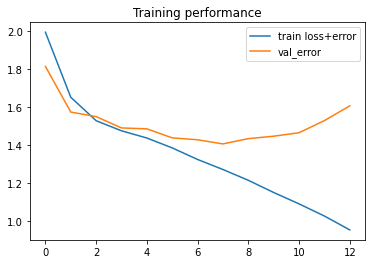

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

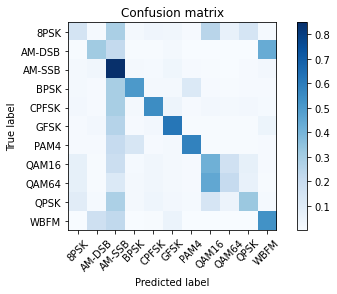

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08983666061705989


Overall Accuracy:  0.09574146783449108


Overall Accuracy:  0.09576703692584809


Overall Accuracy:  0.12541155342711763


Overall Accuracy:  0.13873176540637094


Overall Accuracy:  0.1897076735688185


Overall Accuracy:  0.28402903811252267


Overall Accuracy:  0.3889395320571255


Overall Accuracy:  0.447090744648779


Overall Accuracy:  0.5319537431527693


Overall Accuracy:  0.5879256965944273


Overall Accuracy:  0.6625526791089705


Overall Accuracy:  0.6792569659442724


Overall Accuracy:  0.6951855259122969


Overall Accuracy:  0.6967741935483871


Overall Accuracy:  0.6958887545344619


Overall Accuracy:  0.6925644916540212


Overall Accuracy:  0.6988095238095238


Overall Accuracy:  0.6833884049264043


Overall Accuracy:  0.6943258084197681


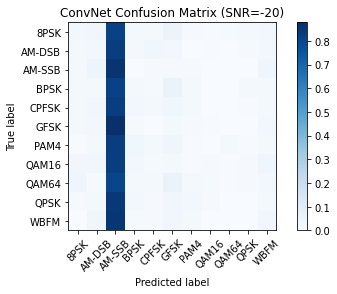

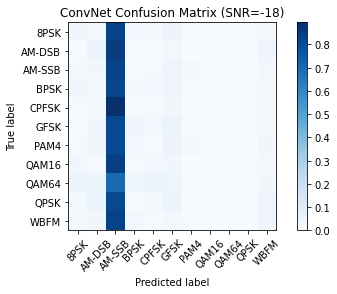

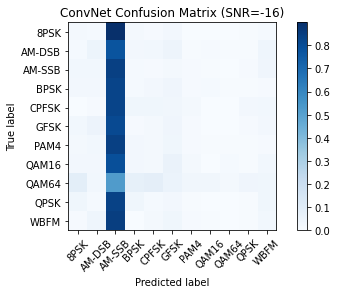

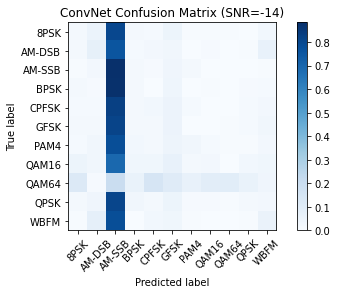

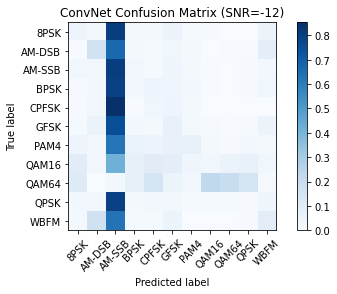

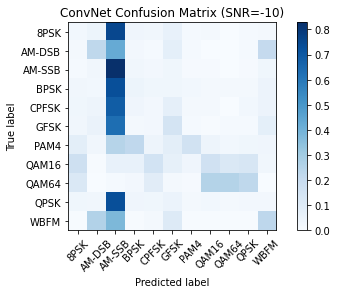

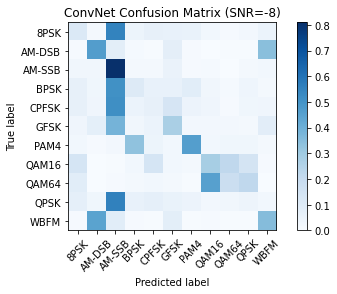

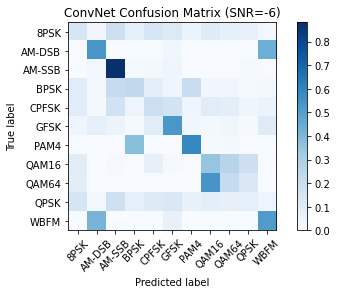

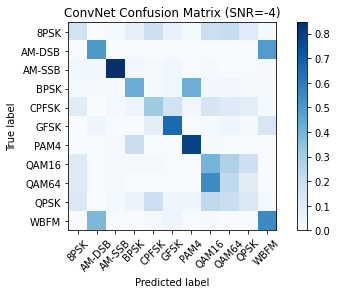

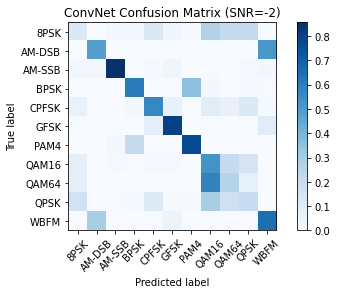

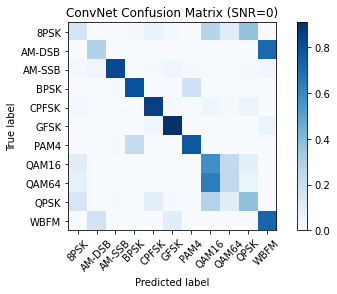

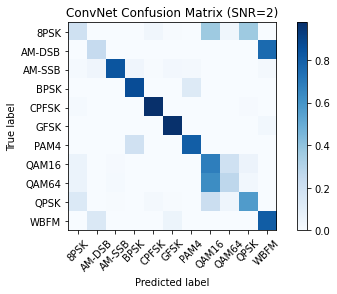

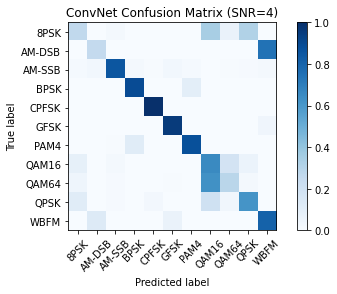

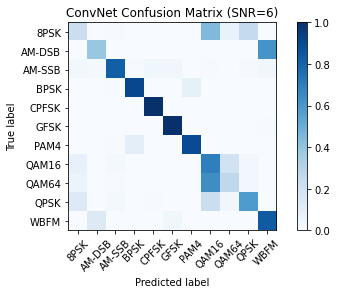

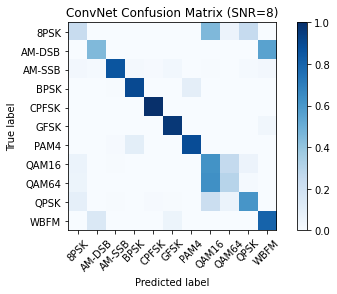

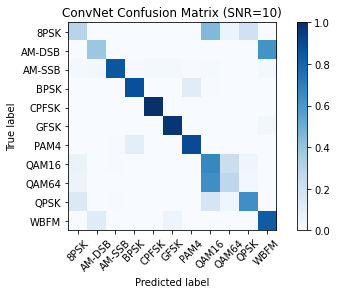

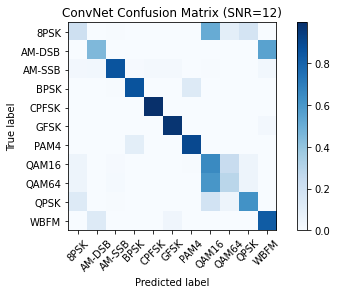

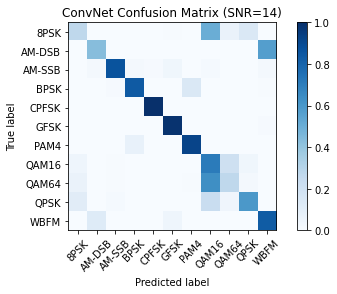

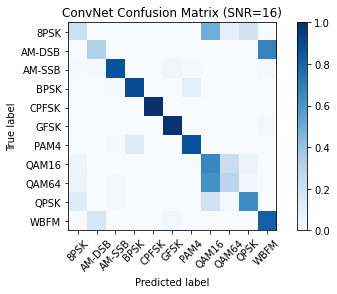

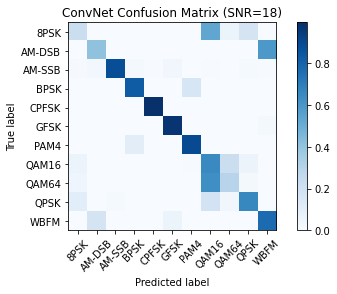

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,12,13,18,28,38,44,53,58,66,67,69,69,69,69,69,68,69


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

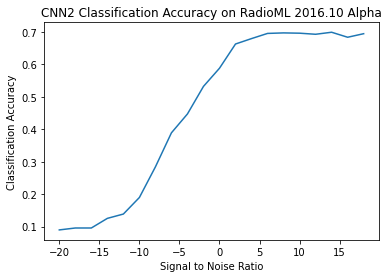

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")